In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
import statsmodels.api as sm
import mlflow
import mlflow.sklearn
from statistics import mean
from mlflow.models.signature import infer_signature
import shap
from catboost import CatBoostClassifier, Pool

# User Defined Functions

In [115]:
class myModel:
    def __init__(self, name, model):
        self.name=name
        self.model=model
        
        
    def log_transform(self, columns:list):
        """Log transforms columns from dataframe that has been cross validated with a hold out dataset

        Args:
            columns: A list of strings representing variable names

        Returns:
            2 train & test dataframes with log transformations applied to applicable columns
        """
        for col in columns:
            Xtrain[col]=np.log(Xtrain[col])
            Xtest[col]=np.log(Xtest[col])

        return Xtrain,Xtest



    def make_data(self, str1:str, str2:str, str3:str):
        """Performs hold out cross validation on dataset with options for selecting variables

        Args:
            str1: A string denoting if the function should return a full or selective dataset
            str2: A string denoting if the function should perform sampling or not
            str3: A list of strings representing variables to select in feature selection


        Returns:
            4 datasets of train test split data with applicable manipulations dependent upon the arguments given (i.e., feature selection, oversampling, none)
        """
        train = pd.read_excel('BBBC-Train.xlsx')
        test = pd.read_excel('BBBC-Test.xlsx')
        data = pd.concat([test, train])
        #data.drop('Observation', axis=1, inplace=True)
    

        if str2 == 'before':
            if str1 == 'full':
                X = data.drop(['Choice'], axis=1)
                y = data['Choice']

                Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=7)
                return Xtrain, Xtest, ytrain, ytest
            elif str1 == 'slim':
                X = data[str3]
                y = data['Choice']
                Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=7)
                return Xtrain, Xtest, ytrain, ytest
            else:
                print('Error')
        elif str2 == 'after':
            if str1 == 'full':
                X = data.drop(['Choice'], axis=1)
                y = data['Choice']
                Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=7)
              # define Pipeline and do random undersampling then SMOTE oversampling of dataset
              # [.8, .5, .2] over

                under = RandomUnderSampler(sampling_strategy=.2)#.2
                over = SMOTE(sampling_strategy=.3) # want about 1500 in minority class and 2000 majority

              # define pipeline steps
                steps = [('u', under), ('o', over)]
                pipeline = Pipeline(steps=steps)
                Xtrain, ytrain = pipeline.fit_resample(Xtrain, ytrain)
                return Xtrain, Xtest, ytrain, ytest
            elif str1 == 'slim':
                X = data[str3]
                y = data['Choice']
                Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=7)
                # define Pipeline and do random undersampling then SMOTE oversampling of dataset
                under = RandomUnderSampler(sampling_strategy=.2)
                over = SMOTE(sampling_strategy=.3) # want about 1500 in minority class and 2000 majority

                # define pipeline steps
                steps = [('u', under), ('o', over)]
                pipeline = Pipeline(steps=steps)
                Xtrain, ytrain = pipeline.fit_resample(Xtrain, ytrain)
                return Xtrain, Xtest, ytrain, ytest
        else:
            print('Error')


    def fit_model(self,model:str,scoring:list,tuning=False, params=list):
        """Fits model and scores with cross validations based on selected metrics
        
        Args:
            model: A chosen Ml model for training
            scoring: A list of metrics to use for scoring over default 5 folds
            tuning: A boolean representing whether hyper parameter tuning should be performed
            params: A dictionary of parameters to be tuned for the given model
            
        Returns:
            1. fit model
            2. A dict holding average metrics over each CV fold
        
        
        """
        model=model
        if tuning == False:

            fit_model = model.fit(Xtrain,ytrain)

            scores = cross_validate(model, Xtest, ytest, scoring=scoring)
            
            print(f"Average Test Accuracy Score: {scores['test_accuracy'].mean()}")
            
            return fit_model, scores
            
        elif tuning == True:
            
            model = GridSearchCV(model, params, cv=5)

            model.fit(Xtrain,ytrain)

            fit_model = model.best_estimator_

            scores = cross_validate(model, Xtest, ytest, scoring=scoring)
            print(f"Average Test Accuracy Score: {scores['test_accuracy'].mean()}")
            
            return fit_model, scores
        
    
    def make_preds(self, fit_model):
        """Creates array of predictions after model training

        Args:
            model:object used to fit the data

        Returns:
            array of predictions on data not seen during training
        """
        
        preds = cross_val_predict(fit_model, Xtest, ytest) # default 5 fold CV
        return preds
      
            
    
    def make_roc(self, preds):
        """Creates a dataframe that stores model tpr,fpr, & auc score in a data frame for future visualizations

        Args:
            preds: array of predictions on data not seen during training

        Returns:
            data frame 
        """
        fpr, tpr, _ = metrics.roc_curve(ytest, preds)
        auc = round(metrics.roc_auc_score(ytest, preds), 4)
        plt.plot(fpr,tpr)
        plt.title(m1.name + " AUC =" + str(auc))
        plt.show()
        
        # index stores TPR so need to reset and rename
        df = pd.DataFrame(fpr,tpr).reset_index()
        df['AUC'] = auc
        df.rename(columns={0:'FPR', 'index':'TPR'}, inplace=True)
        df['Model'] = m1.name
        return df
    
    def make_report(self, preds, df):
        """Creates array of predictions after model training

        Args:
            preds: array of predictions on data not seen during training
            df: new or existing dataframe to hold metrics for future visualizations

        Returns:
            array of predictions on data not seen during training
        """
        # see precision, recall, accuracy
        rpt = (classification_report(ytest,preds, output_dict=True))
        df['Precision_0'] = rpt['0']['precision']
        df['Recall_0'] = rpt['0']['recall']
        df['f1_0'] = rpt['0']['f1-score']
        df['Precision_1'] = rpt['1']['precision']
        df['Recall_1'] = rpt['1']['recall']
        df['f1_1'] = rpt['1']['f1-score']
        df['accuracy'] = rpt['accuracy']
        
        return df 
    
    def make_cm(self, preds, fit_model, df):
       
        cm = confusion_matrix(ytest,preds, labels=fit_model.classes_)

        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = fit_model.classes_)

        disp.plot()
        plt.show()
        df['Not Sold By Model'] = cm[0][1]
        df['Sold by Model'] = cm[1][1]
        df['Missed Opportunities'] = cm[1][0]
        
        return cm
    
 
    
    
    
def get_profit(df):
    
    # profit = revenue - cost
    # profit margin = (revenue - cost )/ revenue
    
    #cost per book
    mailing_cost = 0.65
    manuf_cost = 15
    overhead_cost = manuf_cost * .45
   
    
    #revenue
    selling_price = 31.95
    
    # profit per book
    prof_book = selling_price - mailing_cost - manuf_cost - overhead_cost

    n_cust = 103 # customers who purchased in test set
    total_cust = 780 # total custoemrs in test set
    
    # create empty columns
    df['Profit'] = 0
    df['No Model Profit'] = 0
    df['Profit Boost From Model'] = 0
        
    for i in df.index:
        not_sold_by_model = df['Not Sold By Model'][i]
        sold_by_model = df['Sold by Model'][i]
        missed_opportunities = df['Missed Opportunities'][i]
        total_mailed = not_sold_by_model + sold_by_model
        no_model_total = n_cust
        total_cust = 780
        
        # subtracting mailing expenses and calculating profit for total costs predicted by model
        
        # uncomment for original
        profit = (((missed_opportunities + sold_by_model) * prof_book)- missed_opportunities) - (total_mailed * mailing_cost)
        
        
        # cost with mass marketing campaign
        
         # uncomment for original
        no_model_profit = ((no_model_total * prof_book)-no_model_total) - (total_cust * mailing_cost)
       
     
        df['Profit'][i] = profit 
        df['No Model Profit'][i] = no_model_profit

        df['Profit Boost From Model'][i] = ((profit - no_model_profit)/no_model_profit)*100
        
       
        
        
        
    return df


def calc_metrics(models):
    # # create data frame of required models only
    # models = df[df['Model'].isin(lst)]
    # # reset index since count is off
    
    
    models = models.sort_values('Precision_1', ascending=False)
    models.reset_index(inplace=True)
    
    # output Precision
    plot_p = models.sort_values('Precision_1', ascending=False)
    plt.bar(x=plot_p['Model'], height=plot_p['Precision_1']*100)
    plt.xticks(rotation=90)
    plt.ylim(0,100)
    plt.suptitle(f"Precision on Purchase", fontweight='bold')
    plt.title("How well a model is predicting the response in the minority class out of predicted positives", fontsize='small', style='italic')
    plt.show()
    
     # output Recall
    plot_p = models.sort_values('Recall_1', ascending=False)
    plt.bar(x=plot_p['Model'], height=plot_p['Recall_1']*100)
    plt.xticks(rotation=90)
    plt.ylim(0,100)
    plt.suptitle(f"Recall on Purchase", fontweight='bold')
    plt.title("How well a model is predicting the response in the minority class out of total", fontsize='small', style='italic')
    plt.show()
    
    # get profit
    models = get_profit(models)
    
    models.sort_values('Precision_1', ascending=False, inplace=True)
   
    return models

def calc_metrics2(models):
    
    models.set_index('Model', inplace=True)
    models = models[['Precision_1', 'Recall_1','f1_1', 'accuracy']]
    
    models = models.sort_values('Precision_1', ascending=False).sort_values('Recall_1', ascending=False).sort_values('f1_1', ascending=False).sort_values('accuracy', ascending=False)
    
    
    
    ax = models.plot.bar(rot=0)
    ax.set_xticklabels([x for x in models.index], rotation = 90)
    ax.legend(loc="center")
    
    return ax
           


In [4]:

#viz_df

# Background

In 1994, about 50,000 new titles were published in the US each year, giving rise to a $20B book publishing industry. About 10% of these books are sold through mail order. Recently, online superstores such as Amazon have emerged, carrying 1-2.5M titles and further intensifying the pressure on book clubs and mail order firms. In response to these pressures, book clubs are starting to look at alternative business models that will make them more responsive to their customer’s preferences.

The BBBC, Bookbinders Book Club, was established in 1986 for the purpose of selling specialty books through direct marketing. BBBC is strictly a distributor and does not publish any of the books it sells. In anticipation of using database marketing, BBBC made a strategic decision right from the start to build and maintain a detailed database about its members containing all relevant information about them. Readers fill out an insert and return it to BBBC which then enters the data into the database. 

BBBC is exploring whether to use predictive modeling approaches to improve the efficacy of its direct mail program. For this analysis, we will use a subset of the database available to BBBC. The dependent variable (i.e., response group) for the analysis is `Choice` – purchase or no purchase of the book. BBBC also selected several independent variables that it thought might explain the observed choice behavior. The variables are:
  

| Name | Type | Description	|
|-----|-------|-------------|
|Choice|	int|	If the customer purchased the The Art History of Florence. 1 = purchase and 0 = non-purchase|
|Observation|int|Acts like an Id column to identify customers|
|Gender	|int	|0 = Female and 1 = Male|
|Amount_purchased	|int	|Total money spent on BBBC books|
|Frequency	|int	|Total number of purchases in the chosen period|
|Last_purchase	|int	|Months since last purchase|
|First_purchase	|int	|Months since first purchase|
|P_Child	|int|Number of children’s books purchased|
|P_Youth	|int	|Number of youth’s books purchased|
|P_Cook	|int	|Number of cookbooks purchased|
|P_DIY	|int	|Number of do-it-yourself books purchased|
|P_Art	|int	|Number of art books purchased|  

# EDA

Problem Type:  
This is a supervised classficiation problem using structured data since we are predicting a binary response `0` or `1` for no purchase or purchase, respectivley  

Business Goals/Requirements:
* Goal: 
    * Develop the most accurate model for predicting customers who will purchase the marketing material  
    * Have above 50% accuracy (better than random chance)
    * Maximize profit
* Requirements: 
    * Optimize for Precision.  We want to ensure our model is doing the best job of predicting purchase out of all users who purchase vs optimizing for Recall (predicting purchase out of all users). Precision on purchase will act as our north star during this modeling process among other metrics like recall, f1, and test accuracy
    * Minimize False Positives.  It would be a poor utilization of resources for the company to predict a customer will purchase and they do not purchase.  
    
To avoid data leakage I perform hold out cross valdiation techniques before exploring the data: 

In [5]:
model = LogisticRegression(random_state=7, max_iter=1000)
m1 = myModel('EDA',model)

# make data
x_train, x_test, y_train, y_test = m1.make_data("full", "before", _)

In [6]:
x_train.head()

,Observation,Gender,Amount_purchased,Frequency,Last_purchase,First_purchase,P_Child,P_Youth,P_Cook,P_DIY,P_Art
576,577,1,210,12,1,12,0,0,0,1,0
1522,1523,0,34,4,1,4,0,0,1,0,0
465,466,1,303,2,2,6,0,0,1,0,0
488,489,1,266,34,2,40,0,0,0,0,1
451,452,0,340,14,4,26,3,0,1,0,0


In [7]:
# how many observations will we be training with?
x_train.shape

(3120, 11)

(array([677.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 103.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

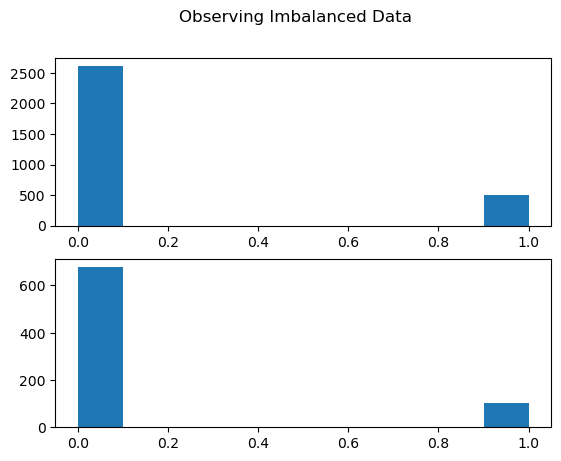

In [8]:
# is response variable balanced?
fig, axs = plt.subplots(2)
fig.suptitle('Observing Imbalanced Data')
axs[0].hist(y_train)
axs[1].hist(y_test)

The response variable is highly imbalanced. Leaving data in its current state could lead to a model that is a poor predictor for the minority class `1` which is our focus in this modeling process.  One of our goals is to best predict customers who _will_ purchase and a model that predicts otherwise will be ineffective.  There are many techniques to overcome this, I will attemmpt 2 and observe the results:
1. Oversampling with SMOTE: This technique is more robust than ordinary Oversampling.  Traditionally we would just clone the same data points until the variable is more optimally balanced. This leads to poor performance as no new information is added to the model and one observation will outweigh all others.  Synthetic Minority Oversampling Technique seeks to correct this by synthesizing new examples from combinations of existing examples.  
2. Undersampling: I will use traditional undersampling to remove oberservations from the majority class.  Research has shown this approach outperforms only Oversampling  ([SMOTE: Synthetic Minority Over-sampling Technique, 2011](https://arxiv.org/abs/1106.1813))  

Modeling Approaches:
This is a supervised classification problem so a few modeling approaches come to mind:
* _Logistic Regression_: it is interpretable and a good baseline model. (Maybe a Naive Bayes model but unsure about all variables being independent of eachother)
* _Random Forest (RF)_: Strong step up from Logit model where we can also gain feature importance from this Embedded Feature Selection approach. We will also tune and observe results
* _Support Vector Classifier (SVC)_: There are less than 10,000 observations so this a viable and powerful approach to this type of problem due to its kernel trick.  We will tune this for optimal results as otherwise we could observe poor performance
* _XGB_: tuning can be time consuming so we will need to select our parameters wisely and it works well on small datasets compared to Random Froest models that generally do not perform well on small data
* _Ensembling_: Will take the best performing models (per our requirements!) and tie together those learnings for what is hopefully an optimal model 

Let's start exploring the basics of the data...

In [9]:
# what kind of data types in train and test
print("Training:")
print(x_train.info())
print()
print("Testing:")
print(x_test.info())

Training:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3120 entries, 576 to 175
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Observation       3120 non-null   int64
 1   Gender            3120 non-null   int64
 2   Amount_purchased  3120 non-null   int64
 3   Frequency         3120 non-null   int64
 4   Last_purchase     3120 non-null   int64
 5   First_purchase    3120 non-null   int64
 6   P_Child           3120 non-null   int64
 7   P_Youth           3120 non-null   int64
 8   P_Cook            3120 non-null   int64
 9   P_DIY             3120 non-null   int64
 10  P_Art             3120 non-null   int64
dtypes: int64(11)
memory usage: 292.5 KB
None

Testing:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 284 to 1277
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Observation       780 non-null    int6

We observe a few things here:
* all data is of type `integer`
* there are no null values in the train or test set

Let's use `describe()` to see some statistical metrics:

In [10]:
x_train.describe()

,Observation,Gender,Amount_purchased,Frequency,Last_purchase,First_purchase,P_Child,P_Youth,P_Cook,P_DIY,P_Art
count,3120.00000,3120.000000,3120.000000,3120.000000,3120.000000,3120.000000,3120.000000,3120.000000,3120.000000,3120.000000,3120.000000
mean,1002.63109,0.670192,196.717949,12.815385,3.106410,22.627564,0.725000,0.347115,0.771795,0.394231,0.372436
std,616.57246,0.470219,94.960142,8.052841,2.942795,15.906823,1.018906,0.644874,1.032576,0.692815,0.675507
min,1.00000,0.000000,15.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,478.00000,0.000000,122.000000,6.000000,1.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,971.00000,1.000000,199.000000,12.000000,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1468.00000,1.000000,268.000000,16.000000,4.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2300.00000,1.000000,474.000000,36.000000,12.000000,96.000000,8.000000,5.000000,6.000000,4.000000,5.000000


Doesn't appear to be any awkwardness to the data meaning theres no negative minimums for `Amount_purchased`. If I was modeling in R I may convert Gender to a Factor but will leave the variable as is in Python since most libraries/algorithms can handle binary variables directly without having to convert. 

Text(0.5, 1.0, 'P_Art')

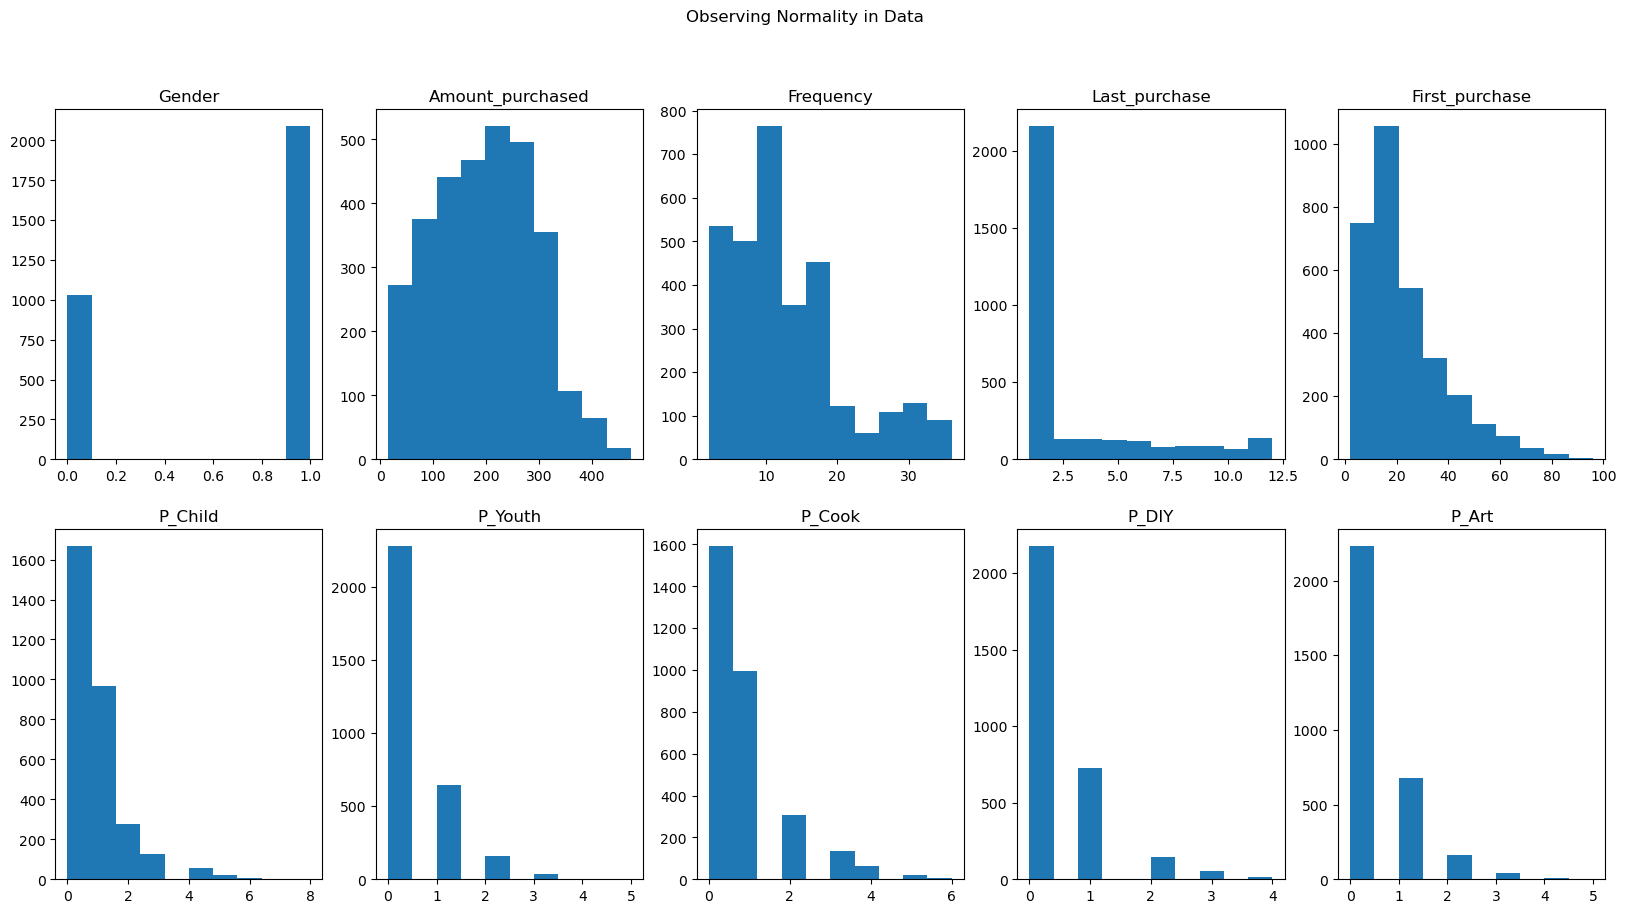

In [11]:
fig, axs = plt.subplots(2,5, figsize = (20,10))
fig.suptitle('Observing Normality in Data')
axs[0][0].hist(x_train['Gender'])
axs[0][1].hist(x_train['Amount_purchased'])
axs[0][2].hist(x_train['Frequency'])
axs[0][3].hist(x_train['Last_purchase'])
axs[0][4].hist(x_train['First_purchase'])
axs[1][0].hist(x_train['P_Child'])
axs[1][1].hist(x_train['P_Youth'])
axs[1][2].hist(x_train['P_Cook'])
axs[1][3].hist(x_train['P_DIY'])
axs[1][4].hist(x_train['P_Art'])

#define subplot titles
axs[0, 0].set_title('Gender')
axs[0, 1].set_title('Amount_purchased')
axs[0, 2].set_title('Frequency')
axs[0, 3].set_title('Last_purchase')
axs[0, 4].set_title('First_purchase')
axs[1, 0].set_title('P_Child')
axs[1, 1].set_title('P_Youth')
axs[1, 2].set_title('P_Cook')
axs[1, 3].set_title('P_DIY')
axs[1, 4].set_title('P_Art')




Disregarding `Gender`, All variables appears slightly right skewed. We could do a log transformation and see if that recenters (normalizes) the data. The log transformation does not work in the range of 0 to 6 because the logarithm function is undefined for values less than or equal to zero. We have many values at zero for multiple variables (i.e., `P_Cook`).  We will not log transform these variables as removing this data would be removing the majority

divide by zero encountered in log


Text(0.5, 1.0, 'First_purchase')

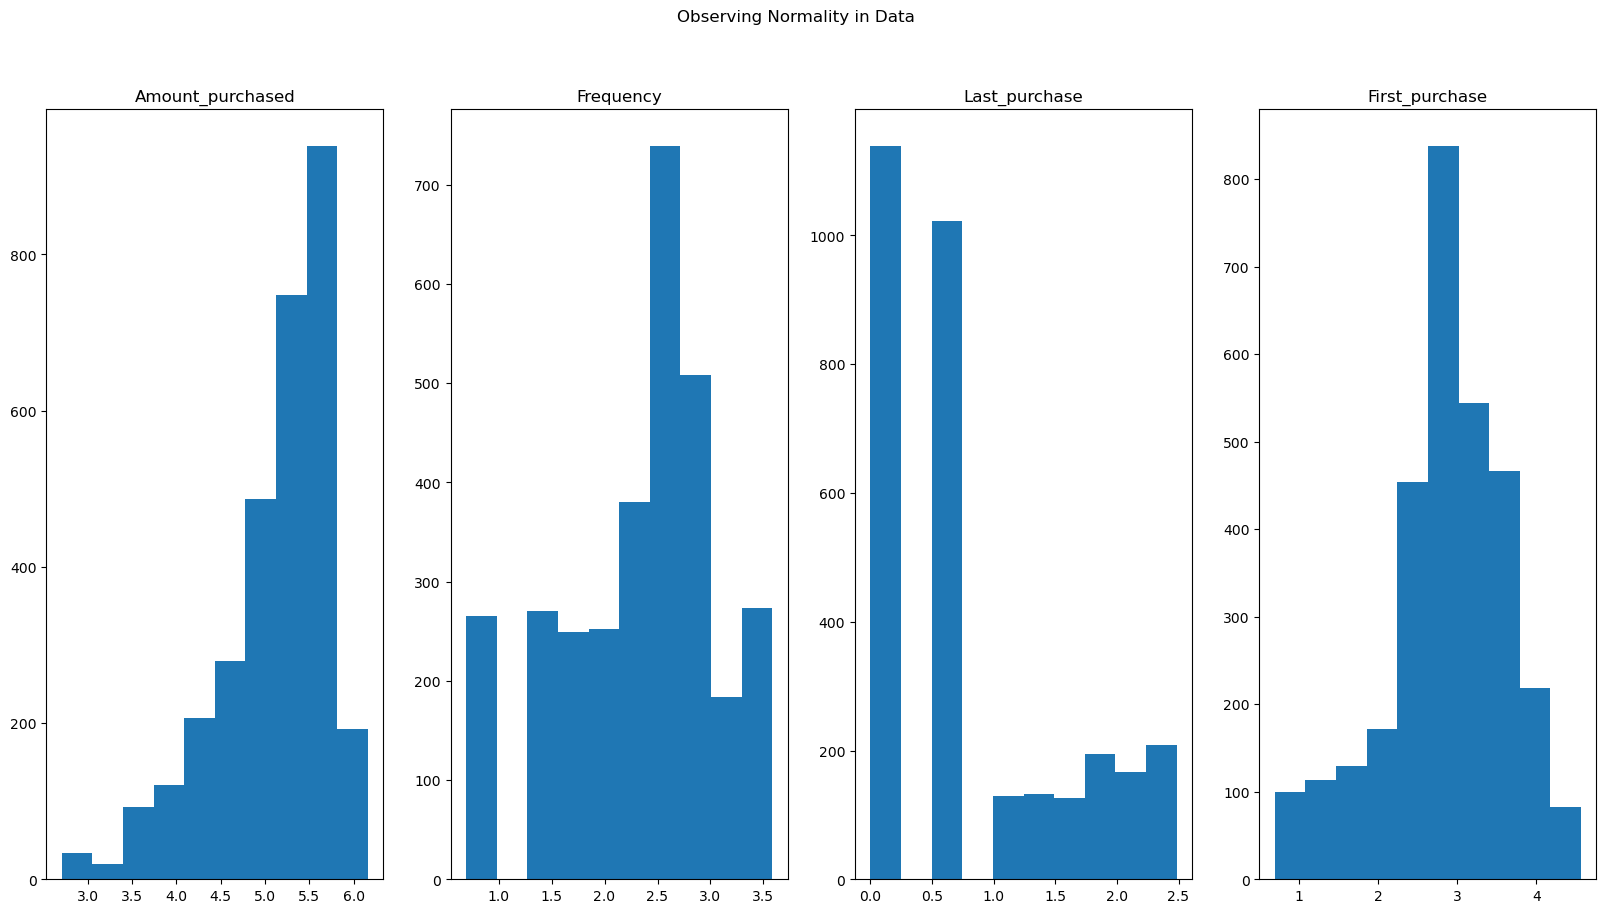

In [12]:
# log transform data
log_xtrain = np.log(x_train)


fig, axs = plt.subplots(1,4, figsize = (20,10))
fig.suptitle('Observing Normality in Data')
#axs[0][0].hist(log_xtrain['Gender'])
axs[0].hist(log_xtrain['Amount_purchased'])
axs[1].hist(log_xtrain['Frequency'])
axs[2].hist(log_xtrain['Last_purchase'])
axs[3].hist(log_xtrain['First_purchase'])
#axs[1][0].hist(log_xtrain['P_Child'])
# axs[1][1].hist(log_xtrain['P_Youth'])
# axs[1][2].hist(log_xtrain['P_Cook'])
# axs[1][3].hist(log_xtrain['P_DIY'])
# axs[1][4].hist(log_xtrain['P_Art'])

#define subplot titles
#axs[0, 0].set_title('Gender')
axs[0].set_title('Amount_purchased')
axs[1].set_title('Frequency')
axs[2].set_title('Last_purchase')
axs[3].set_title('First_purchase')
# axs[1, 0].set_title('P_Child')
# axs[1, 1].set_title('P_Youth')
# axs[1, 2].set_title('P_Cook')
# axs[1, 3].set_title('P_DIY')
# axs[1, 4].set_title('P_Art')





No Transformation Will Be Applied:  
* `Amount_purchased` becomes less normalized so we will not transform this variable. 
* `Last_purchase` is outweighted by the high volume of users sitting around 0 the trasnformation did not help  so we will not transform this variable    

Transformation Applied:  
* `Frequency` and
* `First_purchase` did benefit from the transformation and become more normally distirbuted


Next I will look for any relationships between dependent variables and their relationships with the independent. We will observe a pairplot but want to include the response so we will need to read in the data again

<Figure size 100x500 with 0 Axes>

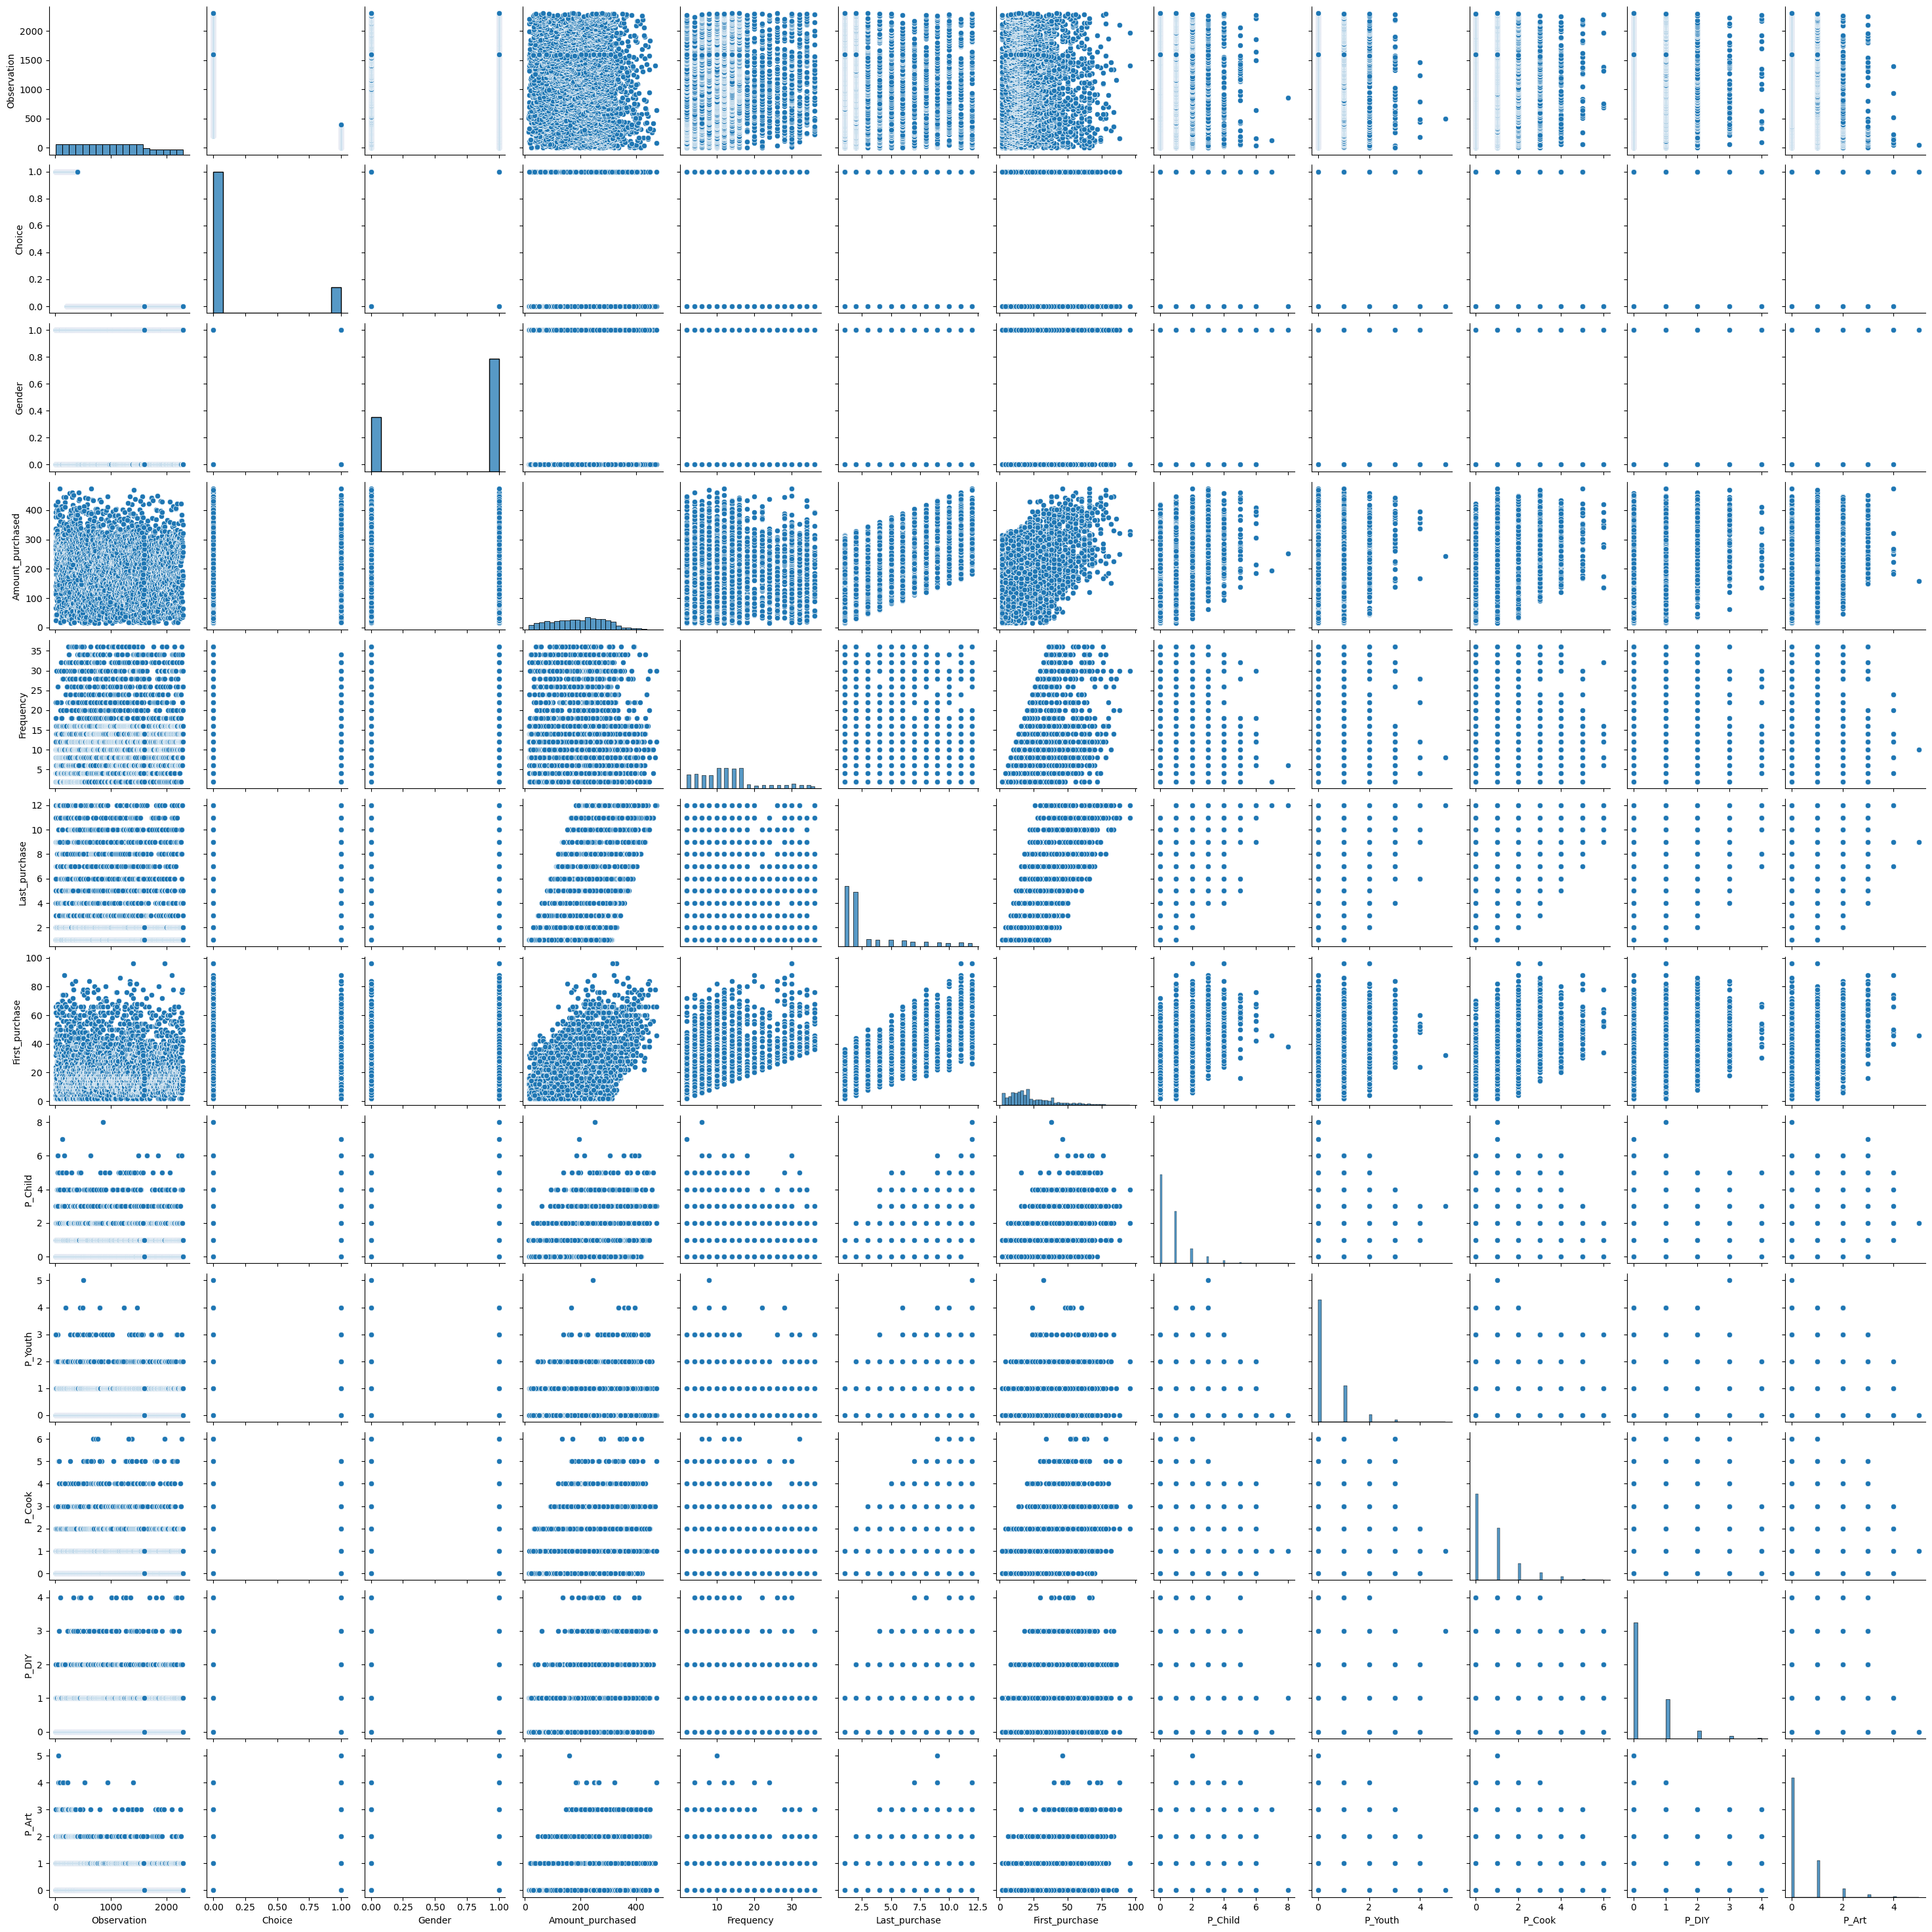

In [13]:
train0 = pd.read_excel('BBBC-Train.xlsx')
test0 = pd.read_excel('BBBC-Test.xlsx')
data0 = pd.concat([test0, train0])
#data0.drop('Observation', axis=1, inplace=True)
plt.figure(figsize=(1,5))
sns.pairplot(data0)
plt.show()

The clearest relationship is with `First_purchase` and `Amount_purchased`. The more months since first purchase the more the customer is likely to spend. Let's plot a heatmap of the same relationships

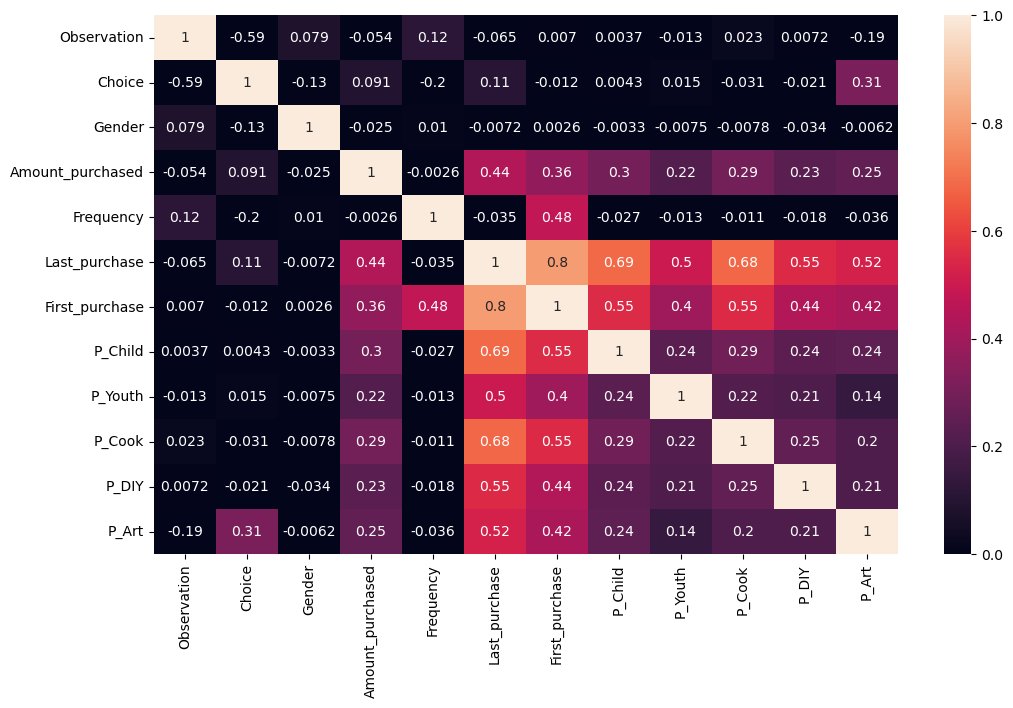

In [14]:
plt.figure(figsize=(12, 7))
sns.heatmap(data0.corr(), annot = True, vmin=0, vmax=1)
plt.show()

Multicollinearity is when two or more independent variables in a regression model are highly correlated with each other. This can be a problem because it can make it difficult to identify the unique effects of each variable on the dependent variable. Additionally, because the independent variables are correlated, the coefficients of the independent variables in the regression equation can change a lot when a new data point is added or when a data point is removed, making the model unstable and unreliable. In this study any correlation over 75% is considered highly correleated

Things to consider from heatmap:
* With our response variable `Choice` there is a small relationship with `P_Art` stating whether the customer purchased art books in the past.  Thsi makes sense as the marketing marterial is for an art book.
* Strong realtionship between `First_purchase` and `Last_purchase` also remembering that `First_purchase` was more normally distributed
* Somewhat strong relationship with `Last_purchase` and `P_Child` as well as `Last_purchase` and `P_Cook`. **This model may benefit from removing `Last_purchase` variable since it is so correlated with multiple variables**
* I'm confused by the high correlation between the response variable and `Observation`. This appears to be an id column that denotes individual customers. How does that indicate purchase?

Let's rethink what the variables represent to identify applications for feature engineering:

| Name | Type | Description	|
|-----|-------|-------------|
|Choice|	int|	If the customer purchased the The Art History of Florence. 1 = purchase and 0 = non-purchase|
|Gender	|int	|0 = Female and 1 = Male|
|Amount_purchased	|int	|Total money spent on BBBC books|
|Frequency	|int	|Total number of purchases in the chosen period|
|Last_purchase	|int	|Months since last purchase|
|First_purchase	|int	|Months since first purchase|
|P_Child	|int|Number of children’s books purchased|
|P_Youth	|int	|Number of youth’s books purchased|
|P_Cook	|int	|Number of cookbooks purchased|
|P_DIY	|int	|Number of do-it-yourself books purchased|
|P_Art	|int	|Number of art books purchased|

* In the real world I would get with stakeholders to clarify the `Frequency` variable more and define what it means to be "within the chosen period". Is that within the sampling period, within a given month?
* without greater context any feature engineering is only speculation and unreliable. 
    * For example, if we knew what specifically was purchased during that `Frequency` that would be more telling.  
    * Having a timestamp variable would make things clearer as well. We could then hone in on which months see more purchases and begin building a forecasting model. We do not have that information so we will keep the variables as they stand.

# Finding Feature Importance Data Modeling

In [124]:
Xtrain, Xtest, ytrain, ytest = m1.make_data("full", "before", _)
# log transform data
Xtrain, Xtest = m1.log_transform(['Frequency', 'First_purchase'])


In [125]:
print_model = sm.Logit(ytrain,Xtrain).fit()
print(print_model.summary())

Optimization terminated successfully.
         Current function value: 0.104651
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                 Choice   No. Observations:                 3120
Model:                          Logit   Df Residuals:                     3109
Method:                           MLE   Df Model:                           10
Date:                Wed, 07 Jun 2023   Pseudo R-squ.:                  0.7625
Time:                        19:10:46   Log-Likelihood:                -326.51
converged:                       True   LL-Null:                       -1374.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Observation         -0.0136      0.001    -16.225      0.000      -0.015      -0.012
Gender    

In [126]:
print_model = sm.Logit(ytrain,Xtrain).fit()
print(print_model.summary())

# convert log odds inot more interpretabl odds
model_odds = pd.DataFrame(np.exp(print_model.params), columns=['OR'])
model_odds


,OR
Observation,0.986478
Gender,0.812346
Amount_purchased,1.007431
Frequency,0.462614
Last_purchase,1.208332
First_purchase,5.312404
P_Child,0.470484
P_Youth,0.669930
P_Cook,0.481769
P_DIY,0.448954


Observing the Logistic Regression, reading the coefficients determine that the following variables have a p-value less than our .05 threshold thus we fail to reject the null hypothesis and find these variables are statsistically significant:  
* Gender
* Amount_purchased
* Frequency
* Last_purchase
* P_Child
* P_Youth
* P_Cook
* P_DIY
* P_Art  

All variables except `First_purchase` were found to be significant according to our log tranformed Logit model

In [17]:
# # make model
# model = RandomForestClassifier(random_state=7)

# m1 = myModel('Log Random Forest Tuned',model)

# # make data
# Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "before", _)

# # log transform data
# Xtrain, Xtest = m1.log_transform(['Frequency', 'First_purchase'])

# # make model
# params = {'n_estimators': [25,50,100,200,500],
#              'max_depth': [2,5,8, 50]}
# log_tuned_rf_model, log_tuned_rf_scores = m1.fit_model(model, ['f1','accuracy'], tuning=True, params=params)


In [18]:
# importances = log_tuned_rf_model.feature_importances_
# std = np.std([tree.feature_importances_ for tree in log_tuned_rf_model.estimators_], axis=0)
# feature_names = [i for i in log_tuned_rf_model.feature_names_in_]
# forest_importances = pd.Series(importances, index=feature_names)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

# Handling Imbalanced Data via Resampling


TODO: Explain metrics: Precision is low for the range of Recall due to the data imbalance and PR curve is outputting an L shape. ROC curve is nto robust to data imbalance and swings wildly so is not completely reliable

After tracking and comparing runs in MlFlow we see there are differences with sampling. It is much better at placing true positives but also has many more false positives

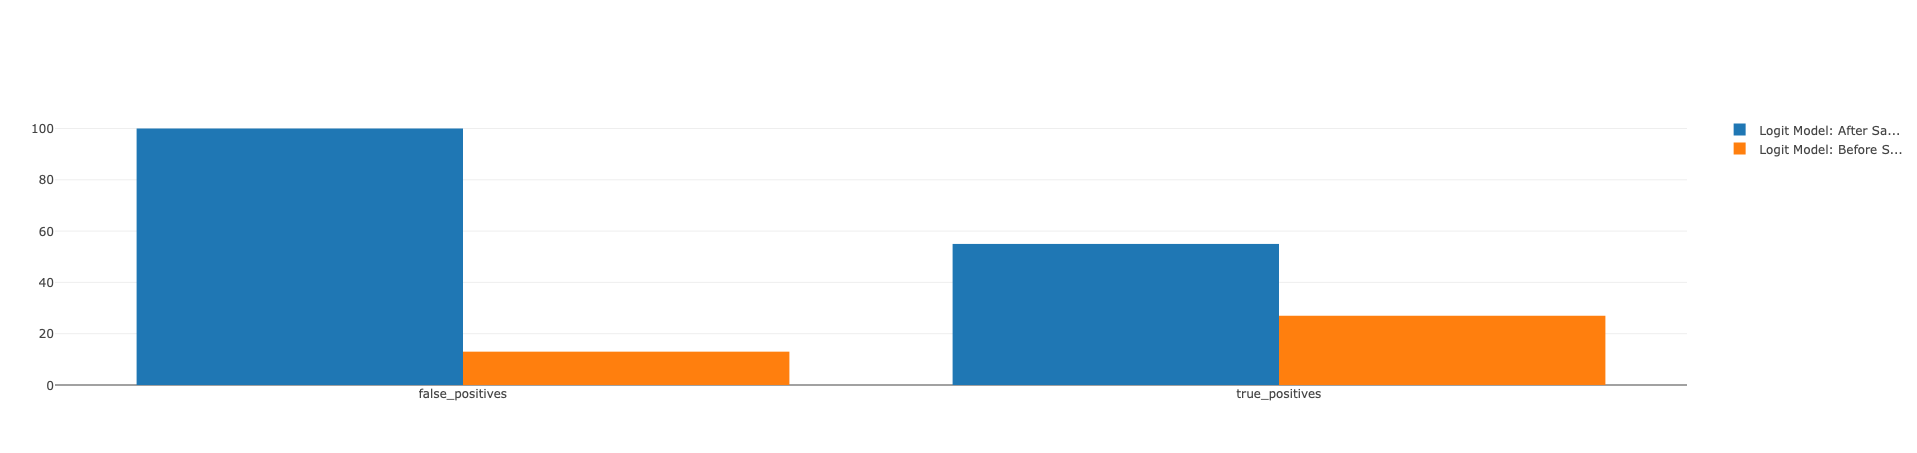  


Logit Model Before Sampling  

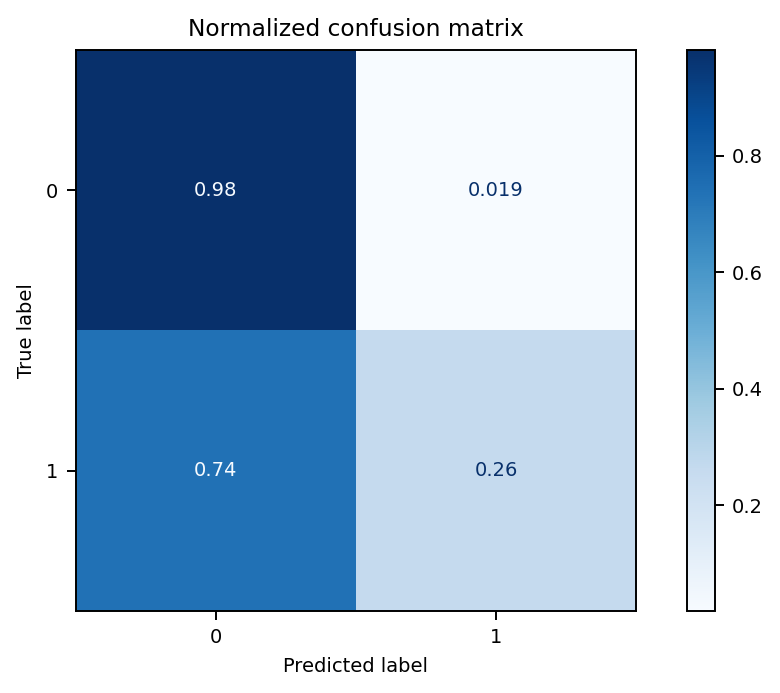    

Logit Model After Sampling  

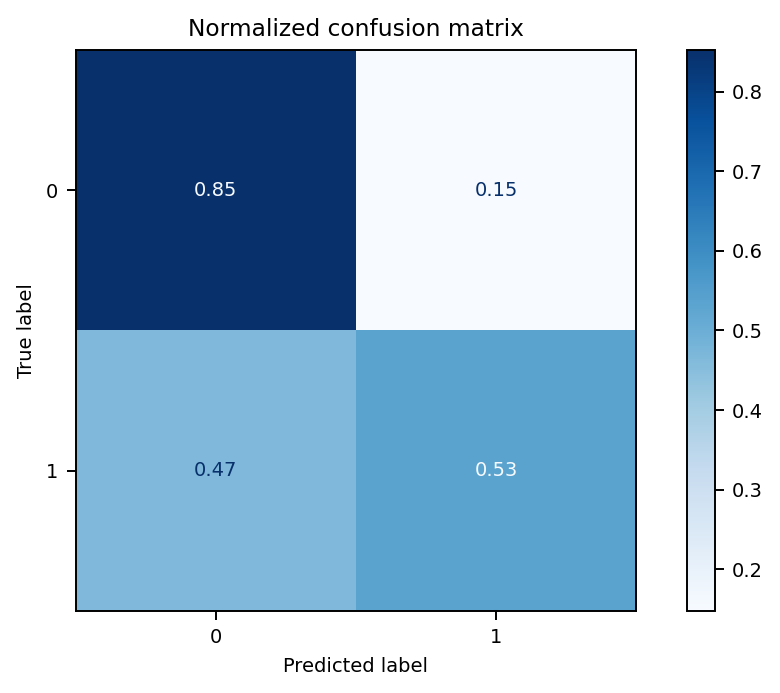  

As shown in the confusion matrices the model has gotten betetr at predicting our minority class after resampling

Axes(0.125,0.11;0.775x0.77)
Average Test Accuracy Score: 0.9730769230769232


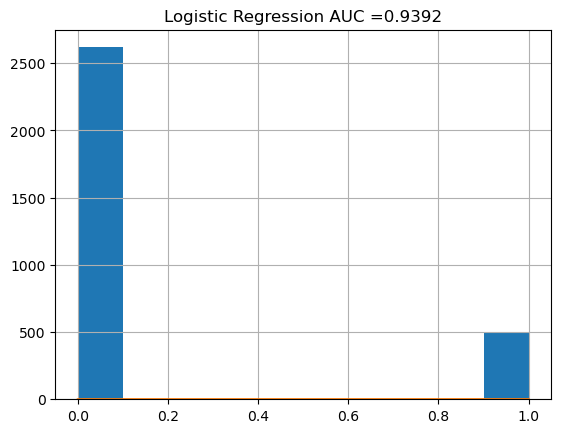

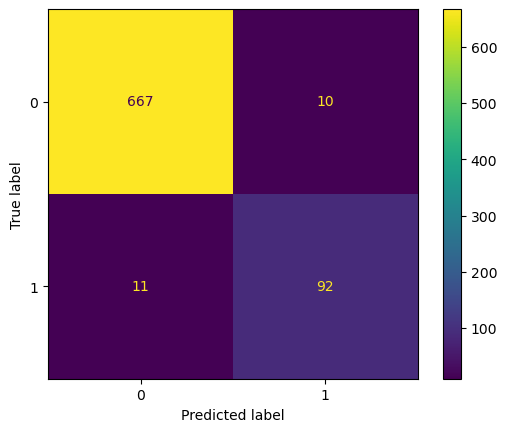

In [19]:
# make model
model = LogisticRegression(random_state=7, max_iter=1000)

m1 = myModel('Logistic Regression',model)

# make data
Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "before", _)
print(ytrain.hist())

# make model
logit_model, logit_scores = m1.fit_model(model, ['f1','accuracy'], tuning=False)

# make predictions
logit_preds = m1.make_preds(logit_model)

# make roc plots
logit_df = m1.make_roc(logit_preds)

# make classification report
logit_rpt = m1.make_report(logit_preds, logit_df)

# make confusion matrix
logit_cm = m1.make_cm(logit_preds, logit_model, logit_rpt)

Axes(0.125,0.11;0.775x0.77)
Average Test Accuracy Score: 0.9730769230769232


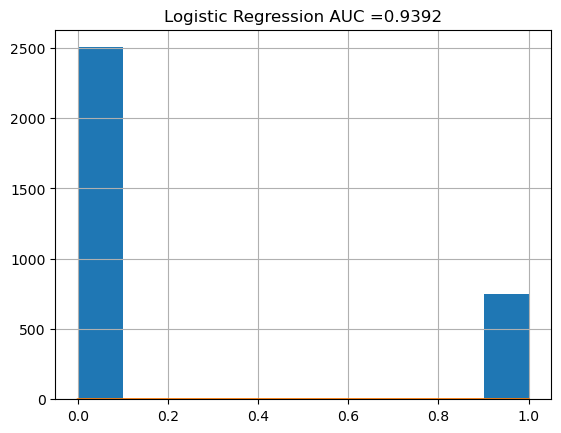

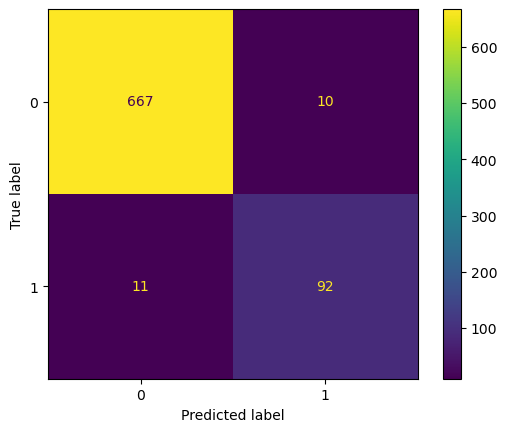

In [20]:
# make model
model = LogisticRegression(random_state=7, max_iter=1000)

m1 = myModel('Logistic Regression',model)

# make data
Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "after", _)
print(ytrain.hist())

# make model
logit_model, logit_scores = m1.fit_model(model, ['f1','accuracy'], tuning=False)

# make predictions
logit_preds = m1.make_preds(logit_model)

# make roc plots
logit_df = m1.make_roc(logit_preds)

# make classification report
logit_rpt = m1.make_report(logit_preds, logit_df)

# make confusion matrix
logit_cm = m1.make_cm(logit_preds, logit_model, logit_rpt)

# Full Data Modeling Before Sampling & Log Transformation

All of my modeling was tracked using MlFlow, an open-source tool to easily track model runs, parameters, and metrics as yoy iterate through the modeling process.  The most optimal models were selected based on a combination of:  
* f1 on test data
* precision on test minority class 
* accuracy on test data
* recall on test data
* number of True Positives and False Positives

## Logit Model

Data Loaded
Average Test Accuracy Score: 0.9730769230769232


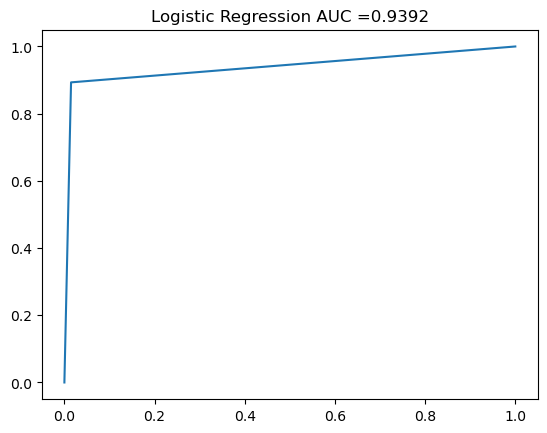

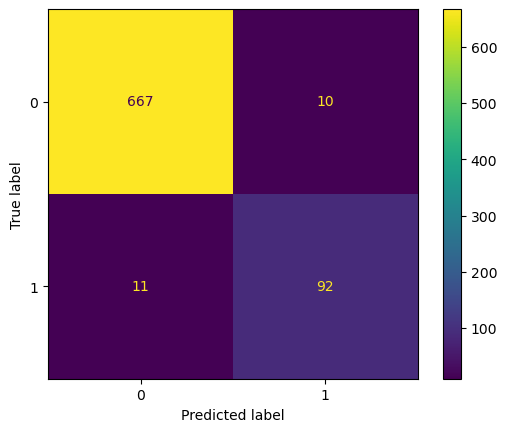

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
Setuptools is replacing distutils.
2023/06/07 18:35:32 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and i

Model Loaded


2023/06/07 18:35:33 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Linear is used.
Unable to serialize underlying model using MLflow, will use SHAP serialization
2023/06/07 18:35:33 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'LogisticRegression' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [21]:
# significant improvement after log trasnformation

mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='next'):
    
    model = LogisticRegression(random_state=7, max_iter=1000)

    m1 = myModel('Logistic Regression',model)
    
   
    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "after", _)
    print("Data Loaded")
    
    #  # log transform data
    # Xtrain, Xtest = m1.log_transform(['Frequency', 'First_purchase'])

    # make model
    logit_model,logit_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=False)
    
    
    # make predictions
    logit_preds = m1.make_preds(logit_model)

    # make roc plots
    logit_df = m1.make_roc(logit_preds)

    # make classification report
    logit_rpt = m1.make_report(logit_preds, logit_df)

    # make confusion matrix
    logit_cm = m1.make_cm(logit_preds, logit_model, logit_rpt)
    
    #signature?
    signature = infer_signature(Xtest, logit_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    
    undersamp = .2
    oversamp = .3
    
#     logit_params = logit_model.get_params()
    
#     # # log parameters
#     # mlflow.log_param('iterations', catboost_params['iterations'])
#     # mlflow.log_param('learning_rate', catboost_params['learning_rate'])
#     # mlflow.log_param('depth', catboost_params['depth'])
#     # mlflow.log_param('bagging_temperature', catboost_params['bagging_temperature'])
#     # mlflow.log_param('loss_function', catboost_params['loss_function'])
   
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(logit_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(logit_scores['test_f1']))
    mlflow.log_metric('precision', mean(logit_scores['test_precision']))
    mlflow.log_metric('recall', mean(logit_scores['test_recall']))
    mlflow.log_metric('oversample', oversamp)
    mlflow.log_metric('undersample', undersamp)
    

    # log model
    mlflow.sklearn.log_model(logit_model, "logit model after002005")
    model_uri = mlflow.get_artifact_uri("logit model after002005")
    print("Model Loaded")
    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

Data Loaded
Average Test Accuracy Score: 0.9730769230769232


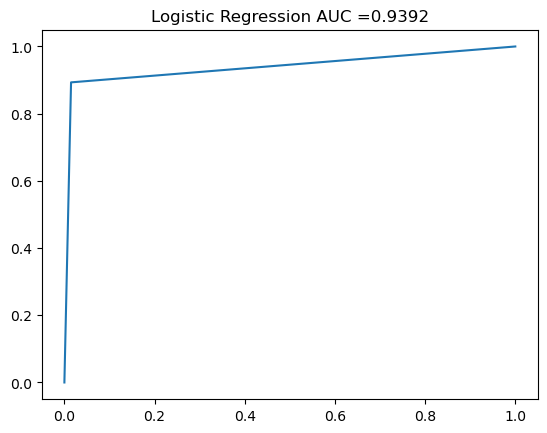

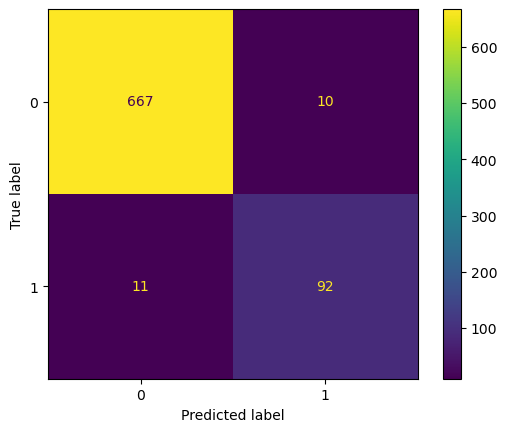

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:35:36 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:35:36 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Linear is used.
Unable to serialize underlying model using MLflow, will use SHAP serialization
2023/06/07 18:35:36 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'LogisticRegression' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [22]:
# significant improvement after log trasnformation

mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='a_logit_final'):
    
    model = LogisticRegression(random_state=7, max_iter=1000)

    m1 = myModel('Logistic Regression',model)
    
   
    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "after", _)
    print("Data Loaded")
    
    #  # log transform data
    # Xtrain, Xtest = m1.log_transform(['Frequency', 'First_purchase'])

    # make model
    logit_model,logit_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=False)
    
    
    # make predictions
    logit_preds = m1.make_preds(logit_model)

    # make roc plots
    logit_df = m1.make_roc(logit_preds)

    # make classification report
    logit_rpt = m1.make_report(logit_preds, logit_df)

    # make confusion matrix
    logit_cm = m1.make_cm(logit_preds, logit_model, logit_rpt)
    
    #signature?
    signature = infer_signature(Xtest, logit_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    
    undersamp = .2
    oversamp = .3
    
#     logit_params = logit_model.get_params()
    
#     # # log parameters
#     # mlflow.log_param('iterations', catboost_params['iterations'])
#     # mlflow.log_param('learning_rate', catboost_params['learning_rate'])
#     # mlflow.log_param('depth', catboost_params['depth'])
#     # mlflow.log_param('bagging_temperature', catboost_params['bagging_temperature'])
#     # mlflow.log_param('loss_function', catboost_params['loss_function'])
   
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(logit_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(logit_scores['test_f1']))
    mlflow.log_metric('precision', mean(logit_scores['test_precision']))
    mlflow.log_metric('recall', mean(logit_scores['test_recall']))
    mlflow.log_metric('oversample', oversamp)
    mlflow.log_metric('undersample', undersamp)
    

    # log model
    mlflow.sklearn.log_model(logit_model, "logit model after002005")
    model_uri = mlflow.get_artifact_uri("logit model after002005")
    print("Model Loaded")
    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

## RF Model


Data Loaded
Average Test Accuracy Score: 0.9564102564102563


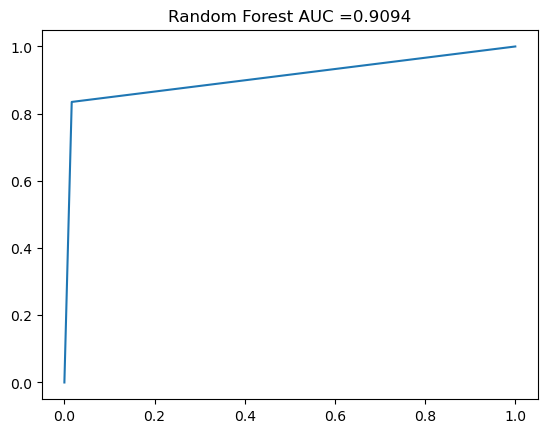

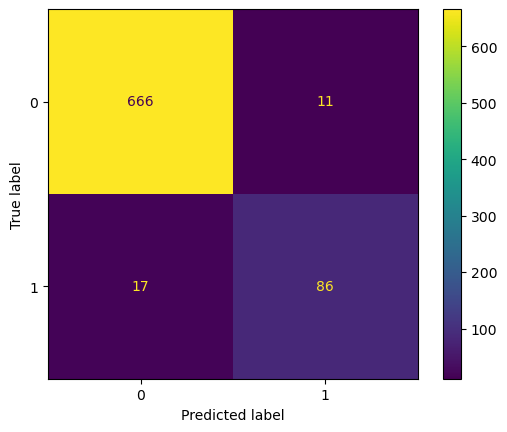

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


Model Loaded


2023/06/07 18:36:48 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2023/06/07 18:36:48 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/06/07 18:36:48 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.


<Figure size 1050x700 with 0 Axes>

In [23]:
# no significant improvment with log transformation

mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='b_rf_final'):
    model = RandomForestClassifier(random_state=7)

    m1 = myModel('Random Forest',model)

    # make data
    
    '''
    
    Random forest is an ideal algorithm to deal with the extreme imbalance owing to two main reasons. 
    Firstly, the ability to incorporate class weights into the random forest classifier makes it cost-sensitive; 
    hence it penalizes misclassifying the minority class. 
    
    '''
    
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "before", _)
    print("Data Loaded")
    
    #  # log transform data
    # Xtrain, Xtest = m1.log_transform(['Frequency', 'First_purchase'])

       
    # make model
    params = {'n_estimators': [25,50,100,200,500],
                 'max_depth': [2,5,8, 50]}
    rf_model, rf_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=True, params=params)
    
    
    # make predictions
    rf_preds = m1.make_preds(rf_model)

    # make roc plots
    rf_df = m1.make_roc(rf_preds)

    # make classification report
    rf_rpt = m1.make_report(rf_preds, rf_df)

    # make confusion matrix
    rf_cm = m1.make_cm(rf_preds, rf_model, rf_rpt)
    
    #signature?
    signature = infer_signature(Xtest, rf_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    
    undersamp = 0
    oversamp = 0
 
    
    rf_params = rf_model.get_params()
    
    # # log parameters
    mlflow.log_param('n_estimators', rf_params['n_estimators'])
    mlflow.log_param('max_depth', rf_params['max_depth'])
   
   
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(rf_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(rf_scores['test_f1']))
    mlflow.log_metric('precision', mean(rf_scores['test_precision']))
    mlflow.log_metric('recall', mean(rf_scores['test_recall']))
    mlflow.log_metric('oversample', oversamp)
    mlflow.log_metric('undersample', undersamp)

    # log model
    mlflow.sklearn.log_model(rf_model, "log rf model")
    model_uri = mlflow.get_artifact_uri("log rf model")
    print("Model Loaded")
    
    
    explainer = shap.Explainer(rf_model, Xtest)
    shap_values = explainer(Xtest)
    shap_exp = shap_values
    
    #evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators="default",
        evaluator_config= {"log_model_explainability":False} # error called when creating beeswarm plot,
    )


    
mlflow.end_run()

## XGB Model

Data Loaded
Average Test Accuracy Score: 0.9730769230769232


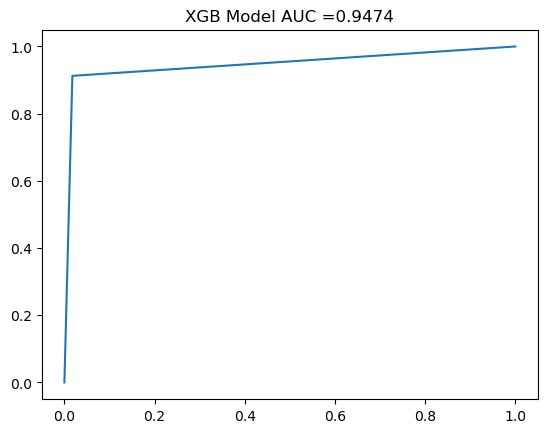

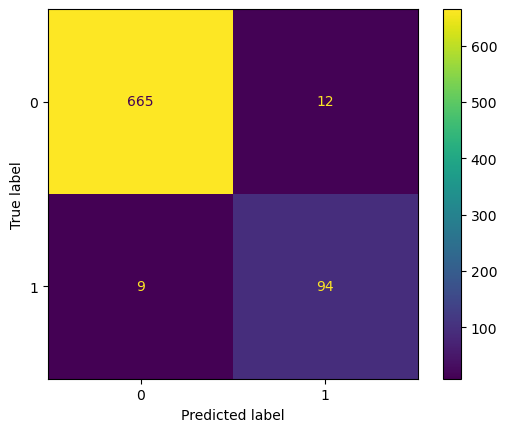

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:36:52 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:36:52 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
Unable to serialize underlying model using MLflow, will use SHAP serialization
2023/06/07 18:36:52 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'TreeEnsemble' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [24]:
# no improvement with log transformattion

mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='b_xgb_final'):
    model = xgb.XGBClassifier(random_state=7,
                             eta=.2,
                             max_depth=3,
                             gamma=1,
                             subsample=1)

    m1 = myModel('XGB Model',model)

    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "before", _)
    print("Data Loaded")
     

    # make model
    params = {'eta' : [0.01, 0.2],
          'max_depth': [3],
          'gamma': [0 , .1],
          'subsample': [0.5, 1]}
    tuned_xgb_model, tuned_xgb_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=False, params=params)

    # make predictions
    tuned_xgb_preds = m1.make_preds(tuned_xgb_model)

    # make roc plots
    tuned_xgb_df = m1.make_roc(tuned_xgb_preds)

    # make classification report
    tuned_xgb_rpt = m1.make_report(tuned_xgb_preds, tuned_xgb_df)

    # make confusion matrix
    tuned_xgb_cm = m1.make_cm(tuned_xgb_preds, tuned_xgb_model, tuned_xgb_rpt)
    
    #signature?
    signature = infer_signature(Xtest, tuned_xgb_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    undersample = 0
    oversample = 0
    
    
    xgb_params = tuned_xgb_model.get_params()
    
    # log parameters
    mlflow.log_param('eta', xgb_params['eta'])
    mlflow.log_param('max_depth', xgb_params['max_depth'])
    mlflow.log_param('gamma', xgb_params['gamma'])
    mlflow.log_param('subsample', xgb_params['subsample'])
   
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(tuned_xgb_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(tuned_xgb_scores['test_f1']))
    mlflow.log_metric('precision', mean(tuned_xgb_scores['test_precision']))
    mlflow.log_metric('recall', mean(tuned_xgb_scores['test_recall']))
    mlflow.log_metric('oversample', oversample)
    mlflow.log_metric('undersample', undersample)

    # log model
    mlflow.sklearn.log_model(tuned_xgb_model, "xgb model")
    model_uri = mlflow.get_artifact_uri("xgb model")
    print("Model Loaded")

    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

In [25]:
# catboost_model.get_all_params()

In [26]:
# catboost_model.get_params()

## CatBoost

Data Loaded
Average Test Accuracy Score: 0.9602564102564102


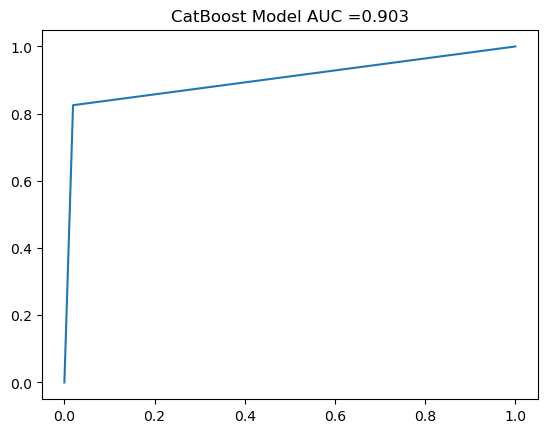

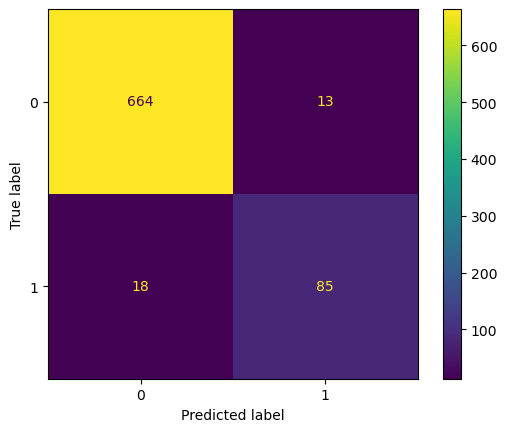

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:37:07 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:37:08 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
Unable to serialize underlying model using MLflow, will use SHAP serialization
2023/06/07 18:37:08 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'TreeEnsemble' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [27]:
# no significant difference after log transformation

mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='b_catboost_final'):
    
    
    params = {'iterations':[2,4, 8, 20, 50],
            'depth': [6,7,8,9]}


    model = CatBoostClassifier(bagging_temperature=0,
                               learning_rate=1,
                           loss_function='Logloss',
                           verbose=False,
                           random_state=7)

    m1 = myModel('CatBoost Model',model)

    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "before", _)
    print("Data Loaded")
    
    catboost_model, catboost_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=True, params=params)
    
    catboost_params = catboost_model.get_params()

    
    # make predictions
    catboost_preds = m1.make_preds(catboost_model)

    # make roc plots
    catboost_df = m1.make_roc(catboost_preds)

    # make classification report
    catboost_rpt = m1.make_report(catboost_preds, catboost_df)

    # make confusion matrix
    catboost_cm = m1.make_cm(catboost_preds, catboost_model, catboost_rpt)
    
    #signature?
    signature = infer_signature(Xtest, catboost_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    undersample = 0
    oversample = 0
    
    
     # log parameters
    mlflow.log_param('iterations', catboost_params['iterations'])
    mlflow.log_param('learning_rate', catboost_params['learning_rate'])
    mlflow.log_param('depth', catboost_params['depth'])
    mlflow.log_param('bagging_temperature', catboost_params['bagging_temperature'])
    mlflow.log_param('loss_function', catboost_params['loss_function'])
    
    # log metrics
    mlflow.log_metric('accuracy', mean(catboost_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(catboost_scores['test_f1']))
    mlflow.log_metric('precision', mean(catboost_scores['test_precision']))
    mlflow.log_metric('recall', mean(catboost_scores['test_recall']))
    mlflow.log_metric('oversample', oversample)
    mlflow.log_metric('undersample', undersample)
     
      

    # log model
    mlflow.sklearn.log_model(catboost_model, "catboost model")
    model_uri = mlflow.get_artifact_uri("catboost model")
    print("Model Loaded")

    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

## Ensembling



Data Loaded
Average Test Accuracy Score: 0.9679487179487178


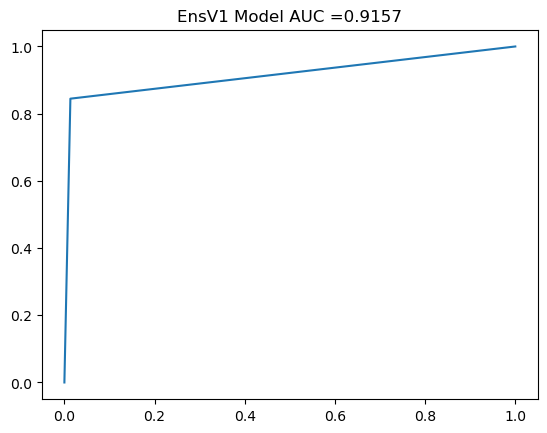

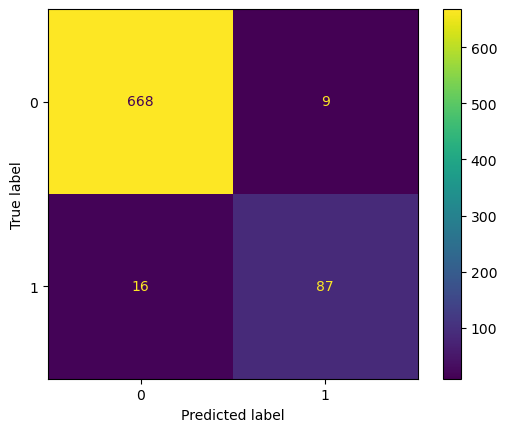

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:37:12 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:37:13 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: TypeError("The passed model is not callable and cannot be analyzed directly with the given masker! Model: VotingClassifier(estimators=[('logit',\n                              LogisticRegression(max_iter=1000,\n                                                 random_state=7)),\n                             ('rf_tuned',\n                              RandomForestClassifier(max_depth=5,\n                                                     n_estimators=50,\n                                                     random_state=7)),\n                             ('xgb',\n                              XGBClassifier(base_score=None, booster=None,\n                                            callbacks=None,\n                                            colsample_bylevel=None,\n                                            colsample_bynode=None,\n                                            colsampl

<Figure size 1050x700 with 0 Axes>

In [28]:
mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='ensv1_final'):
    
    
    #ens v1
    # estimators=[('logit', logit_model), ('rf_tuned', rf_model), ('xgb', tuned_xgb_model)]
    
    # ens v2
    estimators=[('logit', logit_model), ('rf_tuned', rf_model), ('xgb', tuned_xgb_model), ('tuned_sample_catboost', catboost_model)]


    model = VotingClassifier(estimators, voting='hard')

    m1 = myModel('EnsV1 Model',model)

    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "before", _)
    print("Data Loaded")
    
    ensemble_v1_model, ensemble_v1_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=False)

  
    # make predictions
    ensemble_v1_preds = m1.make_preds(ensemble_v1_model)

    # make roc plots
    ensemble_v1_df = m1.make_roc(ensemble_v1_preds)

    # make classification report
    ensemble_v1_rpt = m1.make_report(ensemble_v1_preds, ensemble_v1_df)

    # make confusion matrix
    ens1_cm = m1.make_cm(ensemble_v1_preds, ensemble_v1_model, ensemble_v1_rpt)
    
    #signature?
    signature = infer_signature(Xtest, ensemble_v1_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    undersample = 0
    oversample = 0
    models = {'modl1': 'logit',
             'modl2': 'rf_tuned',
             'modl3': 'xgb',
             'modl4': 'tuned_sample_catboost'}
    
    # log params
    mlflow.log_params(models)
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(ensemble_v1_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(ensemble_v1_scores['test_f1']))
    mlflow.log_metric('precision', mean(ensemble_v1_scores['test_precision']))
    mlflow.log_metric('recall', mean(ensemble_v1_scores['test_recall']))
    mlflow.log_metric('oversample', oversample)
    mlflow.log_metric('undersample', undersample)

    # log model
    mlflow.sklearn.log_model(ensemble_v1_model, "ens2 model")
    model_uri = mlflow.get_artifact_uri("ens2 model")
    print("Model Loaded")

    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

In [29]:
 # old ensembling
# print(classification_report(ytest,ens1_preds))

# Data Modeling After Log Transformation

## Logit Model

Data Loaded
Average Test Accuracy Score: 0.9743589743589745


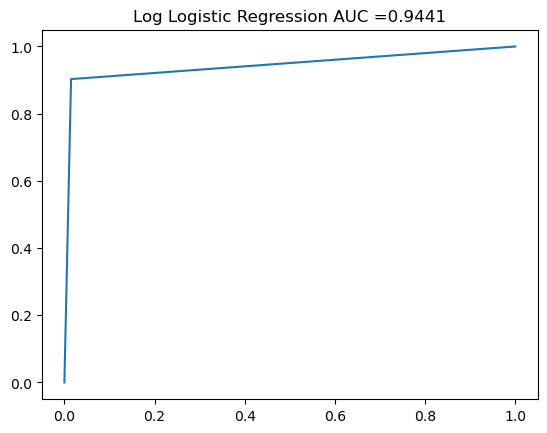

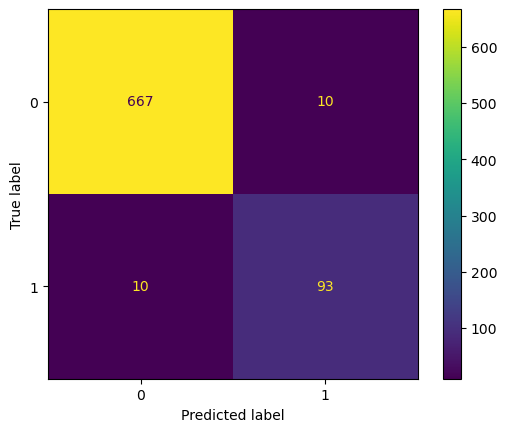

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:37:15 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:37:15 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Linear is used.
Unable to serialize underlying model using MLflow, will use SHAP serialization
2023/06/07 18:37:15 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'LogisticRegression' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [30]:
# significant improvement after log trasnformation

mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='a_log_logit_final'):
    
    model = LogisticRegression(random_state=7, max_iter=1000)

    m1 = myModel('Log Logistic Regression',model)
    
   
    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "after", _)
    print("Data Loaded")
    
     # log transform data
    Xtrain, Xtest = m1.log_transform(['Frequency', 'First_purchase'])

    # make model
    log_logit_model,log_logit_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=False)
    
    
    # make predictions
    log_logit_preds = m1.make_preds(log_logit_model)

    # make roc plots
    log_logit_df = m1.make_roc(log_logit_preds)

    # make classification report
    log_logit_rpt = m1.make_report(log_logit_preds, log_logit_df)

    # make confusion matrix
    log_logit_cm = m1.make_cm(log_logit_preds, log_logit_model, log_logit_rpt)
    
    #signature?
    signature = infer_signature(Xtest, log_logit_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    
    undersamp = .2
    oversamp = .3
    
#     logit_params = logit_model.get_params()
    
#     # # log parameters
#     # mlflow.log_param('iterations', catboost_params['iterations'])
#     # mlflow.log_param('learning_rate', catboost_params['learning_rate'])
#     # mlflow.log_param('depth', catboost_params['depth'])
#     # mlflow.log_param('bagging_temperature', catboost_params['bagging_temperature'])
#     # mlflow.log_param('loss_function', catboost_params['loss_function'])
   
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(log_logit_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(log_logit_scores['test_f1']))
    mlflow.log_metric('precision', mean(log_logit_scores['test_precision']))
    mlflow.log_metric('recall', mean(log_logit_scores['test_recall']))
    mlflow.log_metric('oversample', oversamp)
    mlflow.log_metric('undersample', undersamp)
    

    # log model
    mlflow.sklearn.log_model(log_logit_model, "log_logit model after002003")
    model_uri = mlflow.get_artifact_uri("log_logit model after002003")
    print("Model Loaded")
    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

## RF Model

Data Loaded
Average Test Accuracy Score: 0.9564102564102563


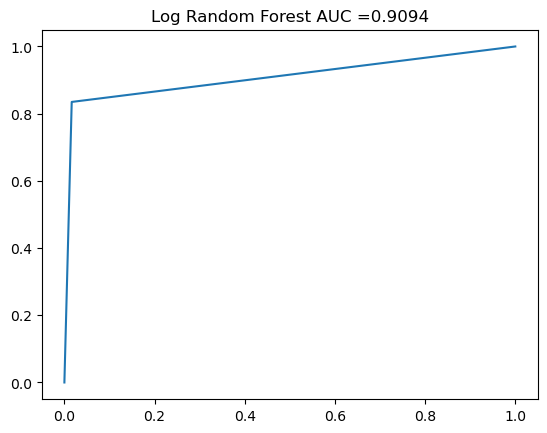

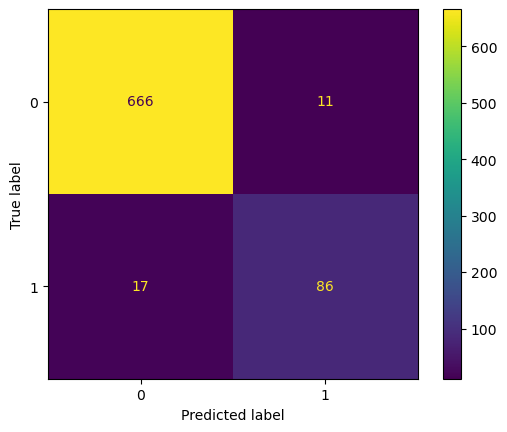

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


Model Loaded


2023/06/07 18:38:26 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2023/06/07 18:38:26 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/06/07 18:38:26 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.


<Figure size 1050x700 with 0 Axes>

In [31]:
# no significant improvment with log transformation

mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='b_log_rf_final'):
    model = RandomForestClassifier(random_state=7)

    m1 = myModel('Log Random Forest',model)

    # make data
    
    '''
    
    Random forest is an ideal algorithm to deal with the extreme imbalance owing to two main reasons. 
    Firstly, the ability to incorporate class weights into the random forest classifier makes it cost-sensitive; 
    hence it penalizes misclassifying the minority class. 
    
    '''
    
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "before", _)
    print("Data Loaded")
    
     # log transform data
    Xtrain, Xtest = m1.log_transform(['Frequency', 'First_purchase'])

       
    # make model
    params = {'n_estimators': [25,50,100,200,500],
                 'max_depth': [2,5,8, 50]}
    log_rf_model, log_rf_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=True, params=params)
    
    
    # make predictions
    log_rf_preds = m1.make_preds(log_rf_model)

    # make roc plots
    log_rf_df = m1.make_roc(log_rf_preds)

    # make classification report
    log_rf_rpt = m1.make_report(log_rf_preds, log_rf_df)

    # make confusion matrix
    log_rf_cm = m1.make_cm(log_rf_preds, log_rf_model, log_rf_rpt)
    
    #signature?
    signature = infer_signature(Xtest, log_rf_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    
    undersamp = 0
    oversamp = 0
 
    
    log_rf_params = log_rf_model.get_params()
    
    # # log parameters
    mlflow.log_param('n_estimators', log_rf_params['n_estimators'])
    mlflow.log_param('max_depth', log_rf_params['max_depth'])
   
   
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(log_rf_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(log_rf_scores['test_f1']))
    mlflow.log_metric('precision', mean(log_rf_scores['test_precision']))
    mlflow.log_metric('recall', mean(log_rf_scores['test_recall']))
    mlflow.log_metric('oversample', oversamp)
    mlflow.log_metric('undersample', undersamp)

    # log model
    mlflow.sklearn.log_model(log_rf_model, "log rf model")
    model_uri = mlflow.get_artifact_uri("log rf model")
    print("Model Loaded")
    
    
    explainer = shap.Explainer(log_rf_model, Xtest)
    shap_values = explainer(Xtest)
    shap_exp = shap_values
    
    #evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators="default",
        evaluator_config= {"log_model_explainability":False} # error called when creating beeswarm plot,
    )


    
mlflow.end_run()

## XGB Model

Data Loaded
Average Test Accuracy Score: 0.9730769230769232


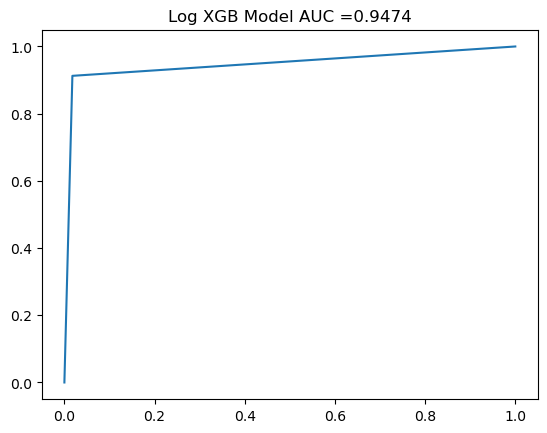

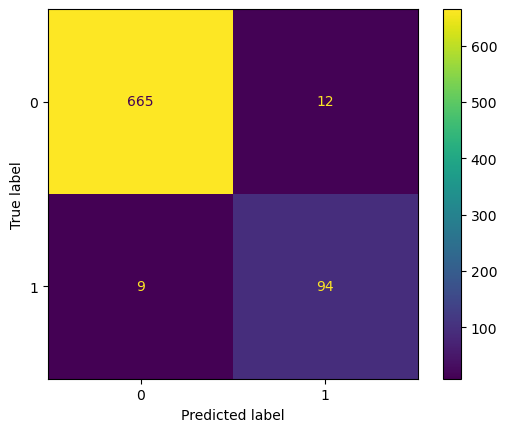

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:38:29 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:38:30 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
Unable to serialize underlying model using MLflow, will use SHAP serialization
2023/06/07 18:38:30 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'TreeEnsemble' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [32]:
# no improvement with log transformattion

mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='b_log_xgb_final'):
    model = xgb.XGBClassifier(random_state=7,
                             eta=.2,
                             max_depth=3,
                             gamma=1,
                             subsample=1)

    m1 = myModel('Log XGB Model',model)

    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "before", _)
    print("Data Loaded")
    
     # log transform data
    Xtrain, Xtest = m1.log_transform(['Frequency', 'First_purchase'])
  

    # make model
    params = {'eta' : [0.2],
          'max_depth': [3],
          'gamma': [0 , .1],
          'subsample': [1]}
    log_tuned_xgb_model, log_tuned_xgb_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=False, params=params)

    # make predictions
    log_tuned_xgb_preds = m1.make_preds(log_tuned_xgb_model)

    # make roc plots
    log_tuned_xgb_df = m1.make_roc(log_tuned_xgb_preds)

    # make classification report
    log_tuned_xgb_rpt = m1.make_report(log_tuned_xgb_preds, log_tuned_xgb_df)

    # make confusion matrix
    log_tuned_xgb_cm = m1.make_cm(log_tuned_xgb_preds, log_tuned_xgb_model, log_tuned_xgb_rpt)
    
    #signature?
    signature = infer_signature(Xtest, log_tuned_xgb_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    undersample = 0
    oversample = 0
    
    
    log_xgb_params = log_tuned_xgb_model.get_params()
    
    # log parameters
    mlflow.log_param('eta', log_xgb_params['eta'])
    mlflow.log_param('max_depth', log_xgb_params['max_depth'])
    mlflow.log_param('gamma', log_xgb_params['gamma'])
    mlflow.log_param('subsample', log_xgb_params['subsample'])
   
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(log_tuned_xgb_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(log_tuned_xgb_scores['test_f1']))
    mlflow.log_metric('precision', mean(log_tuned_xgb_scores['test_precision']))
    mlflow.log_metric('recall', mean(log_tuned_xgb_scores['test_recall']))
    mlflow.log_metric('oversample', oversample)
    mlflow.log_metric('undersample', undersample)

    # log model
    mlflow.sklearn.log_model(log_tuned_xgb_model, "xgb model")
    model_uri = mlflow.get_artifact_uri("xgb model")
    print("Model Loaded")

    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

## CatBoost 

Data Loaded
Average Test Accuracy Score: 0.9564102564102563


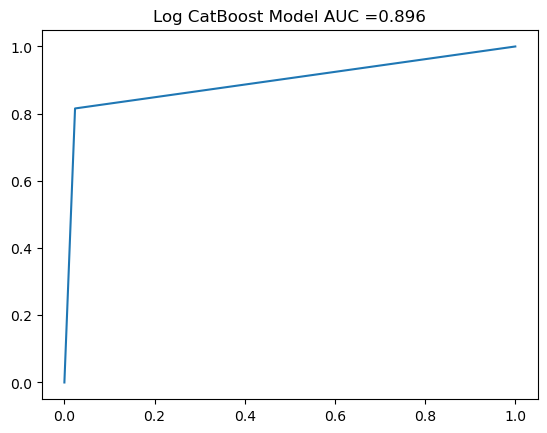

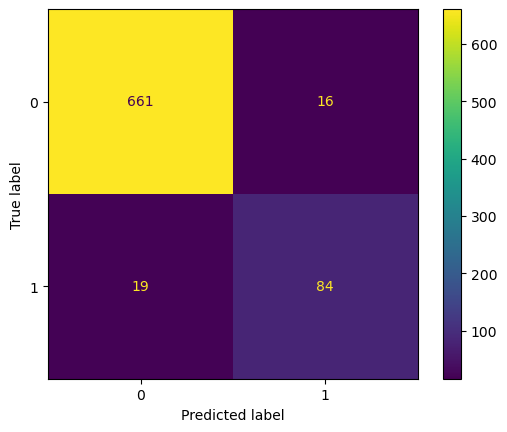

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:38:36 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:38:37 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
Unable to serialize underlying model using MLflow, will use SHAP serialization
2023/06/07 18:38:37 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'TreeEnsemble' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [33]:
mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='b_log_catboost_final'):
    
    
    params = {'iterations':[2,4],
            'depth': [6,7,8,9],
             'bagging_temperature': [0, 10, 50]}


    model = CatBoostClassifier(learning_rate=1,
                           loss_function='Logloss',
                           verbose=False,
                           random_state=7)

    m1 = myModel('Log CatBoost Model',model)

    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "before", _)
    print("Data Loaded")
    
     # log transform data
    Xtrain, Xtest = m1.log_transform(['Frequency', 'First_purchase'])
    
    log_catboost_model, log_catboost_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=True, params=params)
    
    log_catboost_params = log_catboost_model.get_params()

    
    # make predictions
    log_catboost_preds = m1.make_preds(log_catboost_model)

    # make roc plots
    log_catboost_df = m1.make_roc(log_catboost_preds)

    # make classification report
    log_catboost_rpt = m1.make_report(log_catboost_preds, log_catboost_df)

    # make confusion matrix
    log_catboost_cm = m1.make_cm(log_catboost_preds, log_catboost_model, log_catboost_rpt)
    
    #signature?
    signature = infer_signature(Xtest, log_catboost_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    undersample = 0
    oversample = 0
    
    
     # log parameters
    mlflow.log_param('iterations', log_catboost_params['iterations'])
    mlflow.log_param('learning_rate', log_catboost_params['learning_rate'])
    mlflow.log_param('depth', log_catboost_params['depth'])
    mlflow.log_param('bagging_temperature', log_catboost_params['bagging_temperature'])
    mlflow.log_param('loss_function', log_catboost_params['loss_function'])
    
    # log metrics
    mlflow.log_metric('accuracy', mean(log_catboost_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(log_catboost_scores['test_f1']))
    mlflow.log_metric('precision', mean(log_catboost_scores['test_precision']))
    mlflow.log_metric('recall', mean(log_catboost_scores['test_recall']))
    mlflow.log_metric('oversample', oversample)
    mlflow.log_metric('undersample', undersample)
     
      

    # log model
    mlflow.sklearn.log_model(log_catboost_model, "log_catboost model")
    model_uri = mlflow.get_artifact_uri("log_catboost model")
    print("Model Loaded")

    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

## Ensembling

Data Loaded
Average Test Accuracy Score: 0.9705128205128206


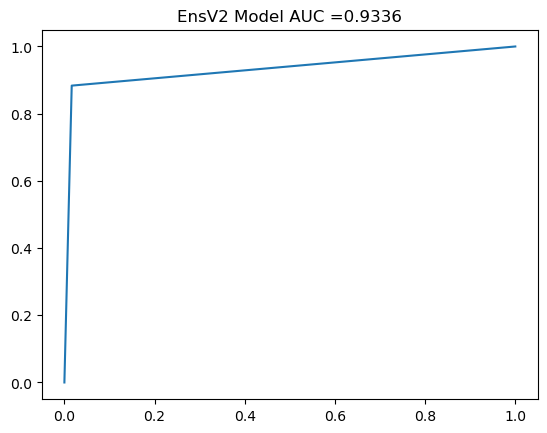

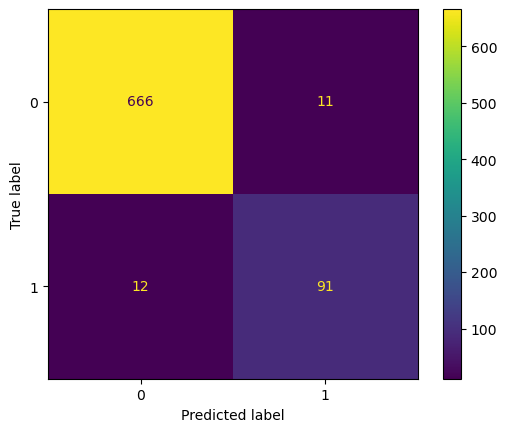

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:38:42 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:38:42 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: TypeError("The passed model is not callable and cannot be analyzed directly with the given masker! Model: VotingClassifier(estimators=[('log logit',\n                              LogisticRegression(max_iter=1000,\n                                                 random_state=7)),\n                             ('logit',\n                              LogisticRegression(max_iter=1000,\n                                                 random_state=7)),\n                             ('rf_tuned',\n                              RandomForestClassifier(max_depth=5,\n                                                     n_estimators=50,\n                                                     random_state=7)),\n                             ('xgb',\n                              XGBClassifier(base_score=None, booster=None,\n                                            callbacks=None,\n            

<Figure size 1050x700 with 0 Axes>

In [34]:
mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='ensv2_final'):
    
    
    #ens v1
    # estimators=[('logit', logit_model), ('rf_tuned', rf_model), ('xgb', tuned_xgb_model)]
    
    # ens v2
    estimators=[('log logit', log_logit_model),('logit', logit_model), ('rf_tuned', rf_model), 
                ('xgb', tuned_xgb_model), ('tuned_sample_catboost', catboost_model)]


    model = VotingClassifier(estimators, voting='hard')

    m1 = myModel('EnsV2 Model',model)

    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "before", _)
    print("Data Loaded")
    
    ensemble_v2_model, ensemble_v2_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=False)

  
    # make predictions
    ensemble_v2_preds = m1.make_preds(ensemble_v2_model)

    # make roc plots
    ensemble_v2_df = m1.make_roc(ensemble_v2_preds)

    # make classification report
    ensemble_v2_rpt = m1.make_report(ensemble_v2_preds, ensemble_v2_df)

    # make confusion matrix
    ens1_cm = m1.make_cm(ensemble_v2_preds, ensemble_v2_model, ensemble_v2_rpt)
    
    #signature?
    signature = infer_signature(Xtest, ensemble_v2_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    undersample = 0
    oversample = 0
    models = {'modl1': 'logit',
             'modl2': 'rf_tuned',
             'modl3': 'xgb',
             'modl4': 'tuned_sample_catboost',
             'modl5': 'log_logit'}
    
    # log params
    mlflow.log_params(models)
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(ensemble_v2_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(ensemble_v2_scores['test_f1']))
    mlflow.log_metric('precision', mean(ensemble_v2_scores['test_precision']))
    mlflow.log_metric('recall', mean(ensemble_v2_scores['test_recall']))
    mlflow.log_metric('oversample', oversample)
    mlflow.log_metric('undersample', undersample)

    # log model
    mlflow.sklearn.log_model(ensemble_v2_model, "ens2 model")
    model_uri = mlflow.get_artifact_uri("ens2 model")
    print("Model Loaded")

    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

# Data Modeling Slim Data 

Only the Logistic Regression model significantly improved after log transformations so all other models will not have this transformation performed going forward in the analysis.  

## Feature Importance: Embedded RF Approach

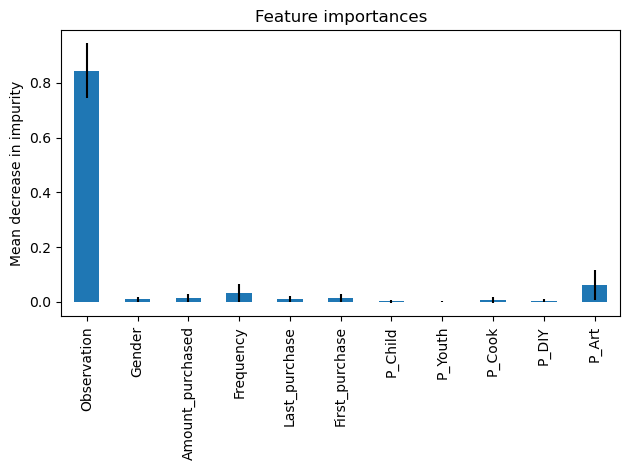

In [35]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
feature_names = [i for i in rf_model.feature_names_in_]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The following variables will be considered important:  
* P_Art
* Amount_purchased
* Frequency
* First_purchase

### Logit Model

Data Loaded
Average Test Accuracy Score: 0.8846153846153847


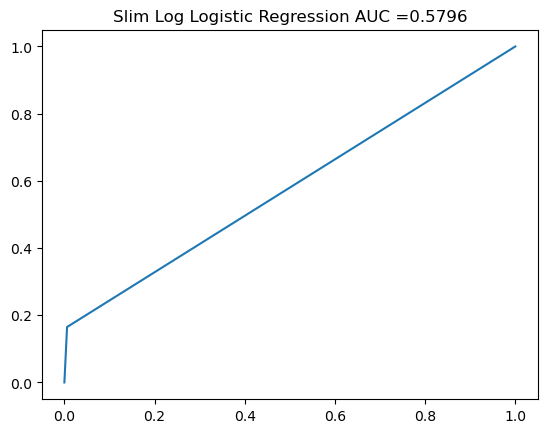

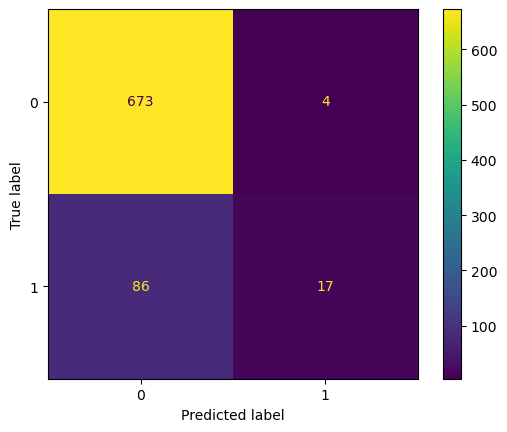

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:38:44 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:38:44 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Linear is used.
Unable to serialize underlying model using MLflow, will use SHAP serialization
2023/06/07 18:38:44 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'LogisticRegression' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [36]:
# significant improvement after slim trasnformation

mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='a_slim_log_logit_final'):
    
    model = LogisticRegression(random_state=7, max_iter=1000)

    m1 = myModel('Slim Log Logistic Regression',model)
    
   
    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("slim", "after", ['P_Art', 'Amount_purchased','Frequency', 'First_purchase'])
    print("Data Loaded")
    
     # log transform data
    Xtrain, Xtest = m1.log_transform(['Frequency', 'First_purchase'])

    # make model
    slim_log_logit_model,slim_log_logit_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=False)
    
    
    # make predictions
    slim_log_logit_preds = m1.make_preds(slim_log_logit_model)

    # make roc plots
    slim_log_logit_df = m1.make_roc(slim_log_logit_preds)

    # make classification report
    slim_log_logit_rpt = m1.make_report(slim_log_logit_preds, slim_log_logit_df)

    # make confusion matrix
    slim_log_logit_cm = m1.make_cm(slim_log_logit_preds, slim_log_logit_model, slim_log_logit_rpt)
    
    #signature?
    signature = infer_signature(Xtest, slim_log_logit_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    
    undersamp = .2
    oversamp = .3
    
#     logit_params = logit_model.get_params()
    
#     # # log parameters
#     # mlflow.log_param('iterations', catboost_params['iterations'])
#     # mlflow.log_param('learning_rate', catboost_params['learning_rate'])
#     # mlflow.log_param('depth', catboost_params['depth'])
#     # mlflow.log_param('bagging_temperature', catboost_params['bagging_temperature'])
#     # mlflow.log_param('loss_function', catboost_params['loss_function'])
   
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(slim_log_logit_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(slim_log_logit_scores['test_f1']))
    mlflow.log_metric('precision', mean(slim_log_logit_scores['test_precision']))
    mlflow.log_metric('recall', mean(slim_log_logit_scores['test_recall']))
    mlflow.log_metric('oversample', oversamp)
    mlflow.log_metric('undersample', undersamp)
    

    # log model
    mlflow.sklearn.log_model(slim_log_logit_model, "slim_log_logit model after002003")
    model_uri = mlflow.get_artifact_uri("slim_log_logit model after002003")
    print("Model Loaded")
    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

### RF Model

Data Loaded
Average Test Accuracy Score: 0.8705128205128204


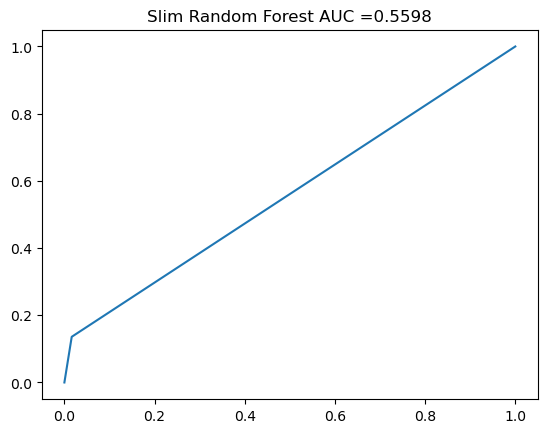

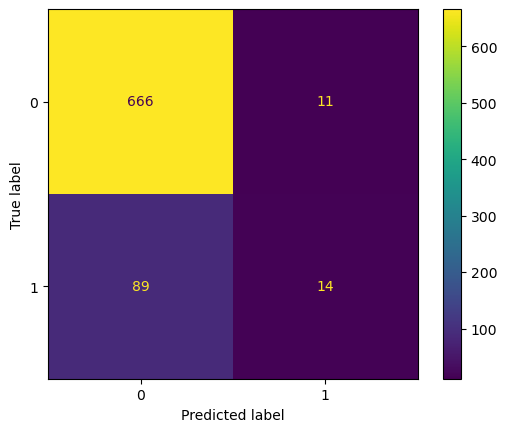

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


Model Loaded


 98%|===================| 1526/1560 [00:18<00:00]        2023/06/07 18:40:18 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2023/06/07 18:40:18 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/06/07 18:40:18 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.


<Figure size 1050x700 with 0 Axes>

In [37]:
# no significant improvment with slim transformation

mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='b_slim_rf_model_final'):
    model = RandomForestClassifier(random_state=7)

    m1 = myModel('Slim Random Forest',model)

    # make data
    
    '''
    
    Random forest is an ideal algorithm to deal with the extreme imbalance owing to two main reasons. 
    Firstly, the ability to incorporate class weights into the random forest classifier makes it cost-sensitive; 
    hence it penalizes misclassifying the minority class. 
    
    '''
    
    Xtrain,Xtest,ytrain,ytest = m1.make_data("slim", "before",  ['P_Art', 'Amount_purchased','Frequency', 'First_purchase'])
    print("Data Loaded")
    
       
    # make model
    params = {'n_estimators': [25,50,100,200,500],
                 'max_depth': [2,5,8, 50]}
    slim_rf_model, slim_rf_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=True, params=params)
    
    
    # make predictions
    slim_rf_preds = m1.make_preds(slim_rf_model)

    # make roc plots
    slim_rf_df = m1.make_roc(slim_rf_preds)

    # make classification report
    slim_rf_rpt = m1.make_report(slim_rf_preds, slim_rf_df)

    # make confusion matrix
    slim_rf_cm = m1.make_cm(slim_rf_preds, slim_rf_model, slim_rf_rpt)
    
    #signature?
    signature = infer_signature(Xtest, slim_rf_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    
    undersamp = 0
    oversamp = 0
 
    
    slim_rf_params = slim_rf_model.get_params()
    
    # # log parameters
    mlflow.log_param('n_estimators', slim_rf_params['n_estimators'])
    mlflow.log_param('max_depth', slim_rf_params['max_depth'])
   
   
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(slim_rf_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(slim_rf_scores['test_f1']))
    mlflow.log_metric('precision', mean(slim_rf_scores['test_precision']))
    mlflow.log_metric('recall', mean(slim_rf_scores['test_recall']))
    mlflow.log_metric('oversample', oversamp)
    mlflow.log_metric('undersample', undersamp)

    # log model
    mlflow.sklearn.log_model(slim_rf_model, "slim_log rf model")
    model_uri = mlflow.get_artifact_uri("slim_log rf model")
    print("Model Loaded")
    
    
    explainer = shap.Explainer(slim_rf_model, Xtest)
    shap_values = explainer(Xtest)
    shap_exp = shap_values
    
    #evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators="default",
        evaluator_config= {"log_model_explainability":False} # error called when creating beeswarm plot,
    )


    
mlflow.end_run()

### XGB Model

Data Loaded
Average Test Accuracy Score: 0.8807692307692306


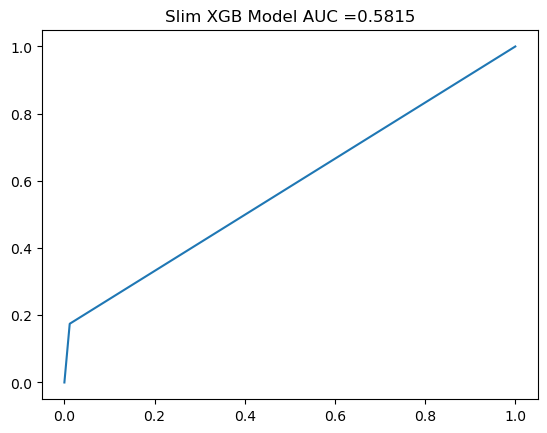

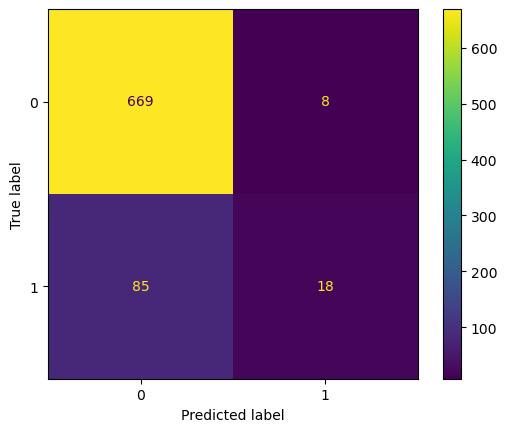

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:40:21 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:40:22 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
Unable to serialize underlying model using MLflow, will use SHAP serialization
2023/06/07 18:40:22 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'TreeEnsemble' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [38]:
# worse with slim transformation

mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='b_slim_xgb_final'):
    model = xgb.XGBClassifier(random_state=7,
                             eta=.2,
                             max_depth=3,
                             gamma=1,
                             subsample=1)

    m1 = myModel('Slim XGB Model',model)

    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("slim", "before", ['P_Art', 'Amount_purchased','Frequency', 'First_purchase'])
    print("Data Loaded")
     

    # make model
    params = {'eta' : [0.01, 0.2],
          'max_depth': [3],
          'gamma': [0 , .1],
          'subsample': [0.5, 1]}
    
    slim_tuned_xgb_model, slim_tuned_xgb_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=False, params=params)

    # make predictions
    slim_tuned_xgb_preds = m1.make_preds(slim_tuned_xgb_model)

    # make roc plots
    slim_tuned_xgb_df = m1.make_roc(slim_tuned_xgb_preds)

    # make classification report
    slim_tuned_xgb_rpt = m1.make_report(slim_tuned_xgb_preds, slim_tuned_xgb_df)

    # make confusion matrix
    slim_tuned_xgb_cm = m1.make_cm(slim_tuned_xgb_preds, slim_tuned_xgb_model, slim_tuned_xgb_rpt)
    
    #signature?
    signature = infer_signature(Xtest, slim_tuned_xgb_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    undersample = 0
    oversample = 0
    
    
    slim_xgb_params = slim_tuned_xgb_model.get_params()
    
    # log parameters
    mlflow.log_param('eta', slim_xgb_params['eta'])
    mlflow.log_param('max_depth', slim_xgb_params['max_depth'])
    mlflow.log_param('gamma', slim_xgb_params['gamma'])
    mlflow.log_param('subsample', slim_xgb_params['subsample'])
   
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(slim_tuned_xgb_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(slim_tuned_xgb_scores['test_f1']))
    mlflow.log_metric('precision', mean(slim_tuned_xgb_scores['test_precision']))
    mlflow.log_metric('recall', mean(slim_tuned_xgb_scores['test_recall']))
    mlflow.log_metric('oversample', oversample)
    mlflow.log_metric('undersample', undersample)

    # log model
    mlflow.sklearn.log_model(slim_tuned_xgb_model, "slim_xgb model")
    model_uri = mlflow.get_artifact_uri("slim_xgb model")
    print("Model Loaded")

    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

### CatBoost

Data Loaded
Average Test Accuracy Score: 0.873076923076923


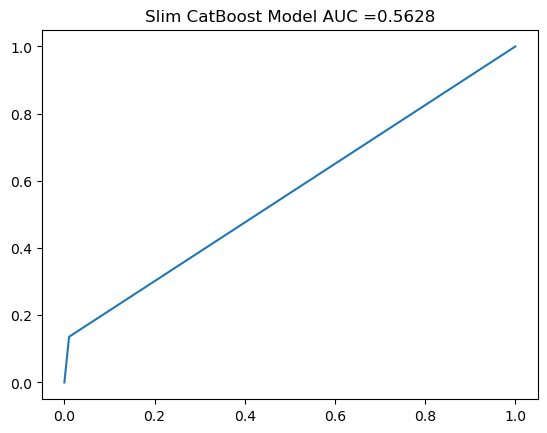

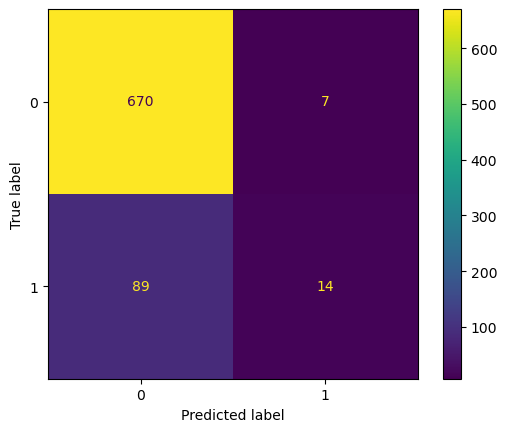

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:40:34 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:40:34 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
Unable to serialize underlying model using MLflow, will use SHAP serialization
2023/06/07 18:40:34 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'TreeEnsemble' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [39]:
# worse with slim transformation

mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='b_slim_catboost_final'):
    
    
    params = {'iterations':[2,4, 8, 20, 50],
            'depth': [6,7,8,9]}


    model = CatBoostClassifier(bagging_temperature=0,
                               learning_rate=1,
                           loss_function='Logloss',
                           verbose=False,
                           random_state=7)

    m1 = myModel('Slim CatBoost Model',model)

    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("slim", "before", ['P_Art', 'Amount_purchased','Frequency', 'First_purchase'])
    print("Data Loaded")
    
    slim_catboost_model, slim_catboost_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=True, params=params)
    
    slim_catboost_params = slim_catboost_model.get_params()

    
    # make predictions
    slim_catboost_preds = m1.make_preds(slim_catboost_model)

    # make roc plots
    slim_catboost_df = m1.make_roc(slim_catboost_preds)

    # make classification report
    slim_catboost_rpt = m1.make_report(slim_catboost_preds, slim_catboost_df)

    # make confusion matrix
    slim_catboost_cm = m1.make_cm(slim_catboost_preds, slim_catboost_model, slim_catboost_rpt)
    
    #signature?
    signature = infer_signature(Xtest, slim_catboost_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    undersample = 0
    oversample = 0
    
    
     # log parameters
    mlflow.log_param('iterations', slim_catboost_params['iterations'])
    mlflow.log_param('learning_rate', slim_catboost_params['learning_rate'])
    mlflow.log_param('depth', slim_catboost_params['depth'])
    mlflow.log_param('bagging_temperature', slim_catboost_params['bagging_temperature'])
    mlflow.log_param('loss_function', slim_catboost_params['loss_function'])
    
    # log metrics
    mlflow.log_metric('accuracy', mean(slim_catboost_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(slim_catboost_scores['test_f1']))
    mlflow.log_metric('precision', mean(slim_catboost_scores['test_precision']))
    mlflow.log_metric('recall', mean(slim_catboost_scores['test_recall']))
    mlflow.log_metric('oversample', oversample)
    mlflow.log_metric('undersample', undersample)
     
      

    # log model
    mlflow.sklearn.log_model(slim_catboost_model, "slim_catboost model")
    model_uri = mlflow.get_artifact_uri("slim_catboost model")
    print("Model Loaded")

    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

### Ensembling

Only Logistic Regression improved with feature selection

Data Loaded
Average Test Accuracy Score: 0.9692307692307693


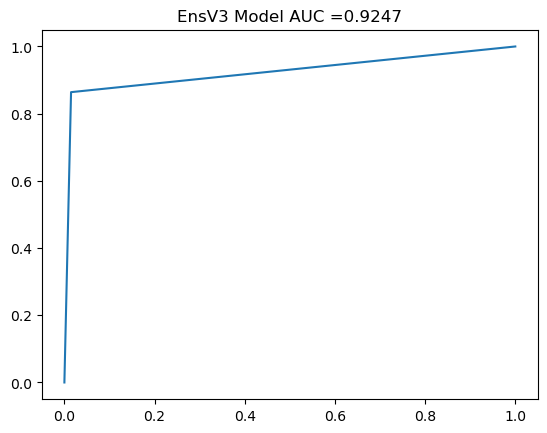

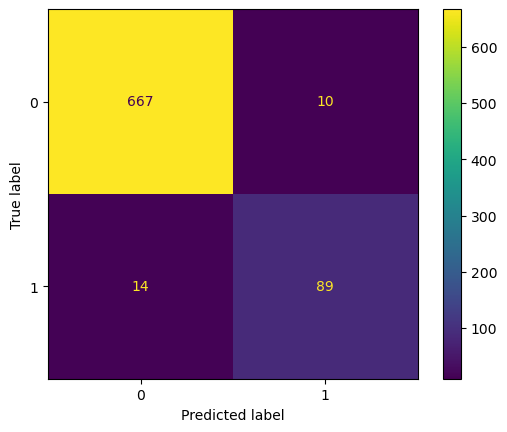

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:40:40 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:40:40 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: TypeError("The passed model is not callable and cannot be analyzed directly with the given masker! Model: VotingClassifier(estimators=[('log logit',\n                              LogisticRegression(max_iter=1000,\n                                                 random_state=7)),\n                             ('logit',\n                              LogisticRegression(max_iter=1000,\n                                                 random_state=7)),\n                             ('rf_tuned',\n                              RandomForestClassifier(max_depth=5,\n                                                     n_estimators=50,\n                                                     random_state=7)),\n                             ('xgb',\n                              XGBClassifier(base_score=None, booster=None,\n                                            callbacks=None,\n            

<Figure size 1050x700 with 0 Axes>

In [40]:
mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='ensv3_final'):
    
    
    #ens v1
    # estimators=[('logit', logit_model), ('rf_tuned', rf_model), ('xgb', tuned_xgb_model)]
    
    # ens v2
    estimators=[('log logit', log_logit_model),('logit', logit_model), ('rf_tuned', rf_model), 
                ('xgb', tuned_xgb_model), ('tuned_sample_catboost', catboost_model), 
               ('slim log logit', slim_log_logit_model)]


    model = VotingClassifier(estimators, voting='hard')

    m1 = myModel('EnsV3 Model',model)

    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "before", _)
    print("Data Loaded")
    
    ensemble_v3_model, ensemble_v3_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=False)

  
    # make predictions
    ensemble_v3_preds = m1.make_preds(ensemble_v3_model)

    # make roc plots
    ensemble_v3_df = m1.make_roc(ensemble_v3_preds)

    # make classification report
    ensemble_v3_rpt = m1.make_report(ensemble_v3_preds, ensemble_v3_df)

    # make confusion matrix
    ens3_cm = m1.make_cm(ensemble_v3_preds, ensemble_v3_model, ensemble_v3_rpt)
    
    #signature?
    signature = infer_signature(Xtest, ensemble_v3_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    undersample = 0
    oversample = 0
    models = {'modl1': 'logit',
             'modl2': 'rf_tuned',
             'modl3': 'xgb',
             'modl4': 'tuned_sample_catboost',
             'modl5': 'log_logit',
             'modl6': 'slim log logit'}
    
    # log params
    mlflow.log_params(models)
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(ensemble_v3_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(ensemble_v3_scores['test_f1']))
    mlflow.log_metric('precision', mean(ensemble_v3_scores['test_precision']))
    mlflow.log_metric('recall', mean(ensemble_v3_scores['test_recall']))
    mlflow.log_metric('oversample', oversample)
    mlflow.log_metric('undersample', undersample)

    # log model
    mlflow.sklearn.log_model(ensemble_v3_model, "ens3 model")
    model_uri = mlflow.get_artifact_uri("ens3 model")
    print("Model Loaded")

    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

Data Loaded
Average Test Accuracy Score: 0.9705128205128206


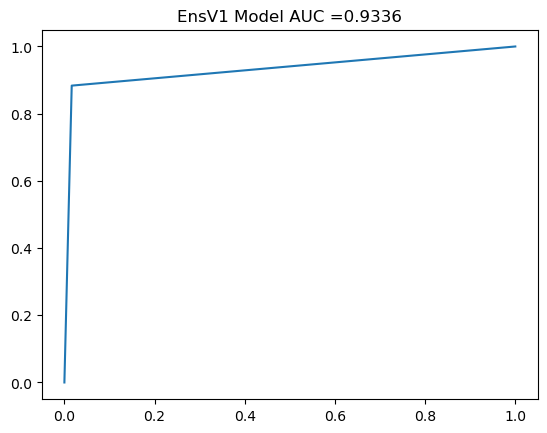

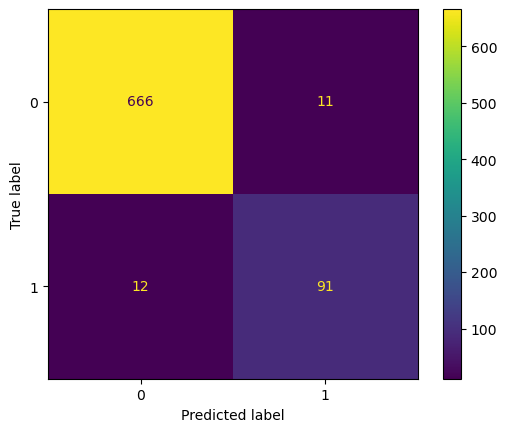

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2023/06/07 18:40:46 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resul

Model Loaded


2023/06/07 18:40:46 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: TypeError("The passed model is not callable and cannot be analyzed directly with the given masker! Model: VotingClassifier(estimators=[('log logit',\n                              LogisticRegression(max_iter=1000,\n                                                 random_state=7)),\n                             ('logit',\n                              LogisticRegression(max_iter=1000,\n                                                 random_state=7)),\n                             ('rf_tuned',\n                              RandomForestClassifier(max_depth=5,\n                                                     n_estimators=50,\n                                                     random_state=7)),\n                             ('xgb',\n                              XGBClassifier(base_score=None, booster=None,\n                                            callbacks=None,\n            

<Figure size 1050x700 with 0 Axes>

In [41]:
mlflow.set_tracking_uri("/Users/coolkid/Desktop/Jupyter/BBBC_Python/Modeling/mlruns/mlruns")

mlflow.set_experiment(experiment_name="BBBC_modeling")


with mlflow.start_run(run_name='ensv4_final'):
    
    
    #ens v1
    # estimators=[('logit', logit_model), ('rf_tuned', rf_model), ('xgb', tuned_xgb_model)]
    
    # ens v2
    estimators=[('log logit', log_logit_model),('logit', logit_model), ('rf_tuned', rf_model), 
                ('xgb', tuned_xgb_model), ('tuned_sample_catboost', catboost_model), 
               ('slim log logit', slim_log_logit_model), ('log_xgb', log_tuned_xgb_model)]


    model = VotingClassifier(estimators, voting='hard')

    m1 = myModel('EnsV1 Model',model)

    # make data
    Xtrain,Xtest,ytrain,ytest = m1.make_data("full", "before", _)
    print("Data Loaded")
    
    ensemble_v4_model, ensemble_v4_scores = m1.fit_model(model, ['f1','accuracy', 'precision', 'recall'], tuning=False)

  
    # make predictions
    ensemble_v4_preds = m1.make_preds(ensemble_v4_model)

    # make roc plots
    ensemble_v4_df = m1.make_roc(ensemble_v4_preds)

    # make classification report
    ensemble_v4_rpt = m1.make_report(ensemble_v4_preds, ensemble_v4_df)

    # make confusion matrix
    ens4_cm = m1.make_cm(ensemble_v4_preds, ensemble_v4_model, ensemble_v4_rpt)
    
    #signature?
    signature = infer_signature(Xtest, ensemble_v4_model.predict(Xtest))
    
    #Build the Evaluation Dataset from the test set
    eval_data = Xtest
    eval_data["label"] = ytest
    undersample = 0
    oversample = 0
    models = {'modl1': 'logit',
             'modl2': 'rf_tuned',
             'modl3': 'xgb',
             'modl4': 'tuned_sample_catboost',
             'modl5': 'log_logit',
             'modl6': 'slim log logit',
             'modl7': 'log_xgb'}
    
    # log params
    mlflow.log_params(models)
    
    
    # log metrics
    mlflow.log_metric('accuracy', mean(ensemble_v4_scores['test_accuracy']))
    mlflow.log_metric('f1', mean(ensemble_v4_scores['test_f1']))
    mlflow.log_metric('precision', mean(ensemble_v4_scores['test_precision']))
    mlflow.log_metric('recall', mean(ensemble_v4_scores['test_recall']))
    mlflow.log_metric('oversample', oversample)
    mlflow.log_metric('undersample', undersample)

    # log model
    mlflow.sklearn.log_model(ensemble_v4_model, "ens4 model")
    model_uri = mlflow.get_artifact_uri("ens4 model")
    print("Model Loaded")

    
    # evaluate model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


    
mlflow.end_run()

In [112]:
viz_df

,TPR,FPR,AUC,Precision_0,Recall_0,f1_0,Precision_1,Recall_1,f1_1,accuracy,Not Sold By Model,Sold by Model,Missed Opportunities
Model,,,,,,,,,,,,,
Logistic Regression,0.893204,0.014771,0.9392,0.983776,0.985229,0.984502,0.901961,0.893204,0.897561,0.973077,10,92,11
Random Forest,0.834951,0.016248,0.9094,0.975110,0.983752,0.979412,0.886598,0.834951,0.860000,0.964103,11,86,17
XGB Model,0.912621,0.017725,0.9474,0.986647,0.982275,0.984456,0.886792,0.912621,0.899522,0.973077,12,94,9
CatBoost Model,0.825243,0.019202,0.9030,0.973607,0.980798,0.977189,0.867347,0.825243,0.845771,0.960256,13,85,18
EnsV1 Model,0.844660,0.013294,0.9157,0.976608,0.986706,0.981631,0.906250,0.844660,0.874372,0.967949,9,87,16
EnsV2 Model,0.883495,0.016248,0.9336,0.982301,0.983752,0.983026,0.892157,0.883495,0.887805,0.970513,11,91,12
EnsV3 Model,0.864078,0.014771,0.9247,0.979442,0.985229,0.982327,0.898990,0.864078,0.881188,0.969231,10,89,14
Log Logistic Regression,0.902913,0.014771,0.9441,0.985229,0.985229,0.985229,0.902913,0.902913,0.902913,0.974359,10,93,10
Slim Log Logistic Regression,0.165049,0.005908,0.5796,0.886693,0.994092,0.937326,0.809524,0.165049,0.274194,0.884615,4,17,86


# DataFrame Creation

> Create data frame that holds ground truth + predcitions for each model to assess accuracy

In [107]:
# '''
# TODO concatenate all data frames together
'''

visualize:
    1. Precision on 1 plus others (recall/f1?) for each model
    2. ROC curve for each model
    3. Test Accuracy for each model
    4. preds for 1 for each model
'''    

viz_df = pd.concat([logit_df,rf_df,tuned_xgb_df,catboost_df,ensemble_v1_df, ensemble_v2_df, ensemble_v3_df,
                   log_logit_df, slim_log_logit_df, log_tuned_xgb_df])




In [108]:
viz_df.sort_values('Precision_1', ascending=False)
viz_df.reset_index(inplace=True)

In [109]:
viz_df = viz_df[viz_df['index']==1]
viz_df.drop('index', inplace=True, axis=1)

# Charts

## Best Metrics from Each Model Type

<Axes: xlabel='Model'>

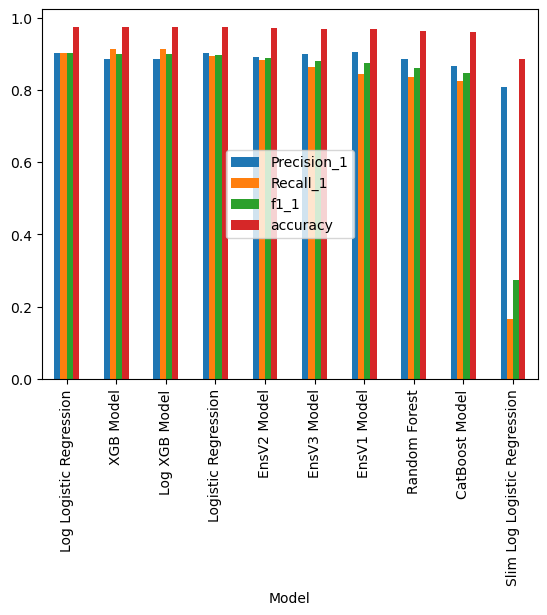

In [110]:
calc_metrics2(viz_df)

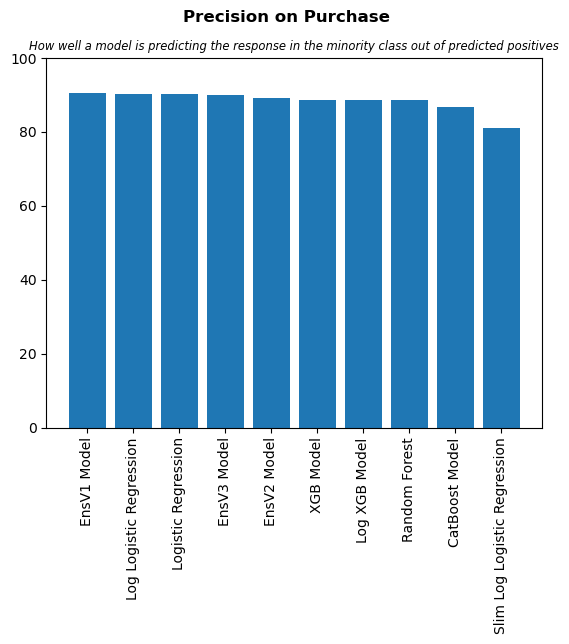

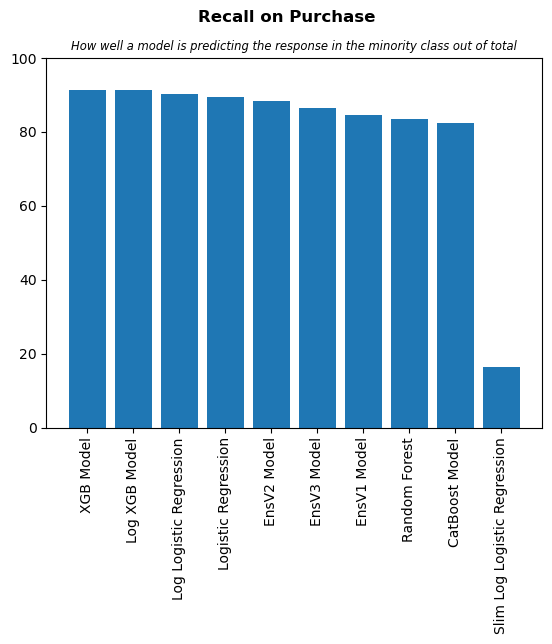


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Model,TPR,FPR,AUC,Precision_0,Recall_0,f1_0,Precision_1,Recall_1,f1_1,accuracy,Not Sold By Model,Sold by Model,Missed Opportunities,Profit,No Model Profit,Profit Boost From Model
0,EnsV1 Model,0.844660,0.013294,0.9157,0.976608,0.986706,0.981631,0.906250,0.844660,0.874372,0.967949,9,87,16,905.25,373.65,142.272180
1,Log Logistic Regression,0.902913,0.014771,0.9441,0.985229,0.985229,0.985229,0.902913,0.902913,0.902913,0.974359,10,93,10,906.70,373.65,142.660244
2,Logistic Regression,0.893204,0.014771,0.9392,0.983776,0.985229,0.984502,0.901961,0.893204,0.897561,0.973077,10,92,11,906.35,373.65,142.566573
3,EnsV3 Model,0.864078,0.014771,0.9247,0.979442,0.985229,0.982327,0.898990,0.864078,0.881188,0.969231,10,89,14,905.30,373.65,142.285561
4,EnsV2 Model,0.883495,0.016248,0.9336,0.982301,0.983752,0.983026,0.892157,0.883495,0.887805,0.970513,11,91,12,905.35,373.65,142.298943
5,XGB Model,0.912621,0.017725,0.9474,0.986647,0.982275,0.984456,0.886792,0.912621,0.899522,0.973077,12,94,9,905.75,373.65,142.405995
6,Log XGB Model,0.912621,0.017725,0.9474,0.986647,0.982275,0.984456,0.886792,0.912621,0.899522,0.973077,12,94,9,905.75,373.65,142.405995
7,Random Forest,0.834951,0.016248,0.9094,0.975110,0.983752,0.979412,0.886598,0.834951,0.860000,0.964103,11,86,17,903.60,373.65,141.830590
8,CatBoost Model,0.825243,0.019202,0.9030,0.973607,0.980798,0.977189,0.867347,0.825243,0.845771,0.960256,13,85,18,901.95,373.65,141.389000
9,Slim Log Logistic Regression,0.165049,0.005908,0.5796,0.886693,0.994092,0.937326,0.809524,0.165049,0.274194,0.884615,4,17,86,884.00,373.65,136.585039


In [116]:
calc_metrics(viz_df)

#### Findings

Placing our top models into a data frame we observe not only the evaluation metrics but the quanitified profit margins alloted by each model compared with the current mass marketing (no model) campaign.  

Utilizing our model BBBC stands to 2X its profits. The most profitable model relative to its costs being `Ensemble_V1`.  This model has a +145% profit margin and stands to make 881.30 compared to 373.65 without a model

Now lets use this optimal model to create a **Marketing List**

In [122]:
df_preds = pd.DataFrame(ytest)
df_preds['ensv1']= ensemble_v1_preds
df_preds.reset_index(inplace=True)
df_preds.rename(columns={'index':'CustomerId'}, inplace=True)
df_preds

,CustomerId,Choice,ensv1
0,284,1,0
1,244,1,0
2,1134,0,0
3,440,0,0
4,820,0,0
...,...,...,...
775,1179,0,0
776,577,0,0
777,1309,0,0
778,760,0,0


# Marketing List

Now let's select some observations that will be likely to purchase our material.  This could be used to generate leads for marketers in the company.

In [123]:
test = df_preds[df_preds['Choice']==1]
test_final = test[test['ensv1']==1]
test_final

,CustomerId,Choice,ensv1
5,98,1,1
8,21,1,1
13,62,1,1
31,109,1,1
39,110,1,1
...,...,...,...
739,91,1,1
742,33,1,1
750,99,1,1
759,193,1,1


# Recommendations

In [127]:
print_model = sm.Logit(ytrain,Xtrain).fit()
print(print_model.summary())

# convert log odds inot more interpretabl odds
model_odds = pd.DataFrame(np.exp(print_model.params), columns=['OR'])
model_odds



Optimization terminated successfully.
         Current function value: 0.104651
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                 Choice   No. Observations:                 3120
Model:                          Logit   Df Residuals:                     3109
Method:                           MLE   Df Model:                           10
Date:                Wed, 07 Jun 2023   Pseudo R-squ.:                  0.7625
Time:                        19:20:18   Log-Likelihood:                -326.51
converged:                       True   LL-Null:                       -1374.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Observation         -0.0136      0.001    -16.225      0.000      -0.015      -0.012
Gender    

,OR
Observation,0.986478
Gender,0.812346
Amount_purchased,1.007431
Frequency,0.462614
Last_purchase,1.208332
First_purchase,5.312404
P_Child,0.470484
P_Youth,0.669930
P_Cook,0.481769
P_DIY,0.448954


The variable `Observation` is clearly an important metric. I made a drastic improvement in predicting potential customers. Before only correclty predicting 11 being boosted to 11 after including the variable.  All modeling efforts seemed to suffer from feature selection in this specific use case. Each feature was impactful to the response outcome. In terms of customer selection I recommend the company targets `Frequency` and `P_Art`. It seems obvious but this interpretation can be applicable to all sorts of data problems in the real world. BBBC shoudl focus on:
1. Customers who have a low number of purchases in the chosen period.
     * The odds of purchase decrease by a factor of ~0.4 for every one unit increase in `Frequency`
2. Those who have purchased more art books
    * The odds of purchase increase by a factor of ~1.9 for every one unit increase in `P_Art`

